# Evaluating the dilution hypothesis

Negative selection against Neanderthal introgression is currently widely accepted as an explanation for this decline. However, after testing of previously proposed models of selection against introgression (mainly selection against Neanderthal variants that accumulated in the Neanderthal population due to their low $N_e$) we find that these models cannot produce the continuous decline in Neanderthal ancestry observed in the real data.

There are at least two possible alternative explanations. One is a more complex selection model, perhaps some form of negative epistasis (this is what we are currently investigating). The second model involves a dilution of Neanderthal ancestry during part of the last 55 thousand years.

Several earlier studies indicate that a simple dilution scenario is not entirely implausible:

1. European individuals seem to carry various proportions of ancestry from three ancestral populations, one of them being a mysterious "basal Eurasian" population. [@lazaridis_ancient_2014]
2. Ancient modern human samples from the Upper Palaeolithic Europe show (beginning around 14ky) affinity towards present-day Near East populations. [@fu_genetic_2016]
3. Ancient Near East individuals derive part of their ancestry from the basal Eurasian population, which appears to have had much lower amounts of Neanderthal ancestry than any ancient or present-day modern human. [@lazaridis_genomic_2016]. If the ancient Near Easterners experienced dilution of their Neanderthal ancestry and they also admixed with EMHs in Europe, it follows that Neanderthal ancestry in Europeans was diluted as well.

This notebook contains a very simple exploratory analysis to evaluate whether this dilution hypothesis is possible.

In [1]:
suppressPackageStartupMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all/"

EIGENSTRAT_PREFIX <- paste0(EIGENSTRAT_DIR, "UPA_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_all.transitions.snp")

In [4]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

### Generate a table of SNPs to filter out (transitions)

In [5]:
read_snp(SNP_FILE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

In [6]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

In [7]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# Testing the affinity towards present-day populations using D statistic

We used an approach similar to the method used in the Ice Age paper [Fu et al., 2016] (Supplementary note 11, page 59), but using the full set of EMH samples and also adding the present-day Europeans (which were missing in the Fu et al., 2016 paper). Specifically, we calculated the following D statistic for each ancient or present-day European X:



$D(\textrm{Kostenki14}, \textrm{X}; \textrm{present-day population}, \textrm{Mbuti})$,



which tests whether a given individual X shares more alleles with some of the present-day human populations than with an ancient hunter gatherer Kostenki 14.

In [245]:
set_dim <- function(w, h, r=150) {
    options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r)
}
    
plot_z <- function(df, z_cut=3) {
    print(ggplot(df) +
        geom_point(aes(age, Zscore, color=Y, size=n_snps), alpha=1/2) +
        facet_wrap(~Y, ncol=2) +
        geom_hline(yintercept=c(z_cut, -z_cut), linetype=2, color="red") +
        xlim(30000, 0) + ylim(min(df_affinity_chimp_ui$Zscore), z_cut) +
        theme_bw(base_size=20) +
        ggtitle(paste0("D(", unique(df$W), ", test_X; SGDP pop Y; ", unique(df$Z), ")"),
                paste0(unique(df$set), " SNPs")))
}
    
plot_d <- function(df) {
    print(ggplot(df) +
        geom_point(aes(age, D, color=Y, size=n_snps), alpha=1/2) +
        facet_wrap(~Y, ncol=2) +
        geom_hline(yintercept=0, linetype=3) +
        xlim(30000, 0) + #ylim(min(df_affinity_chimp_ui$Zscore), z_cut) +
        theme_bw(base_size=20) +
        ggtitle(paste0("D(", unique(df$W), ", test_X; SGDP pop Y; ", unique(df$Z), ")"),
                paste0(unique(df$set), " SNPs")))
}

Prepare the list of populations used in the rest of our analysis:

In [8]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
#    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)

ancient_X <- filter(samples, pop == "EMH", !name %in% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["NearEast"]])$name

Calculate the D statistics above for each present-day SGDP population:

## Mbuti outgroup - all SNPs

In [9]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Mbuti",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Mbuti",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti[[pop]] <- bind_rows(ancient, modern)
}

In [192]:
df_affinity_mbuti <- bind_rows(affinity_dstats_mbuti) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="all")

Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message:
“Removed 60 rows containing missing values (geom_point).”

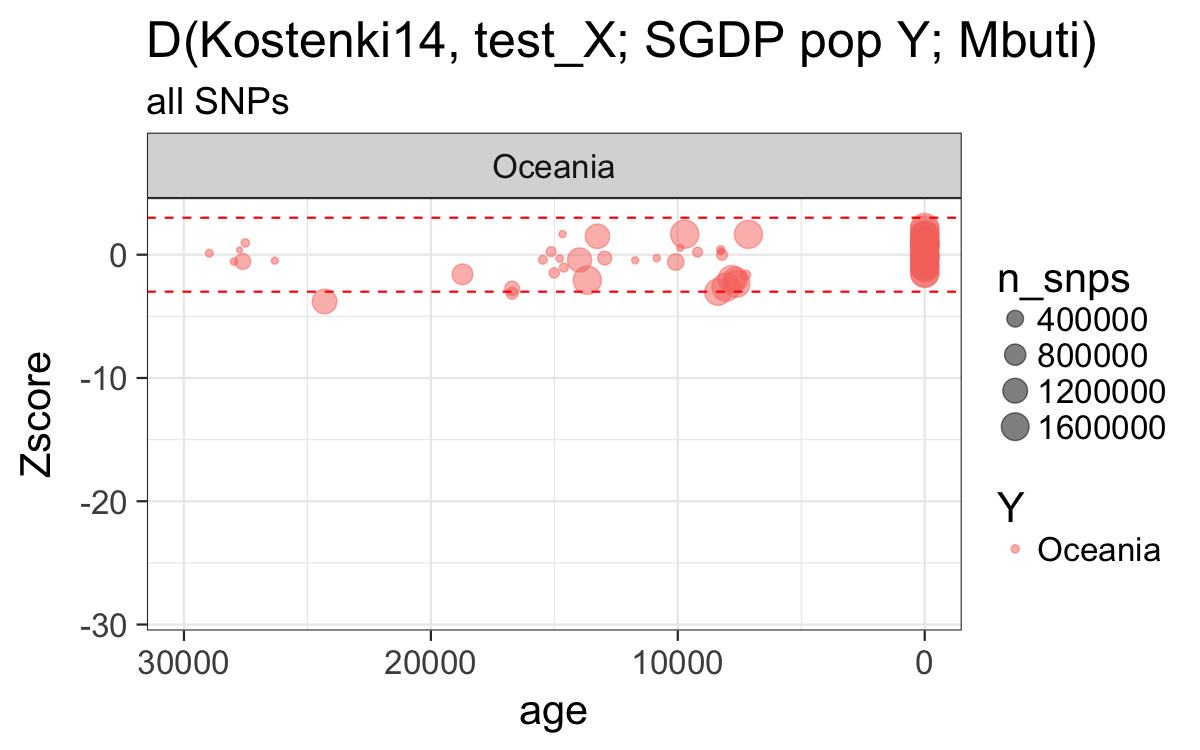

Warning message:
“Removed 36 rows containing missing values (geom_point).”

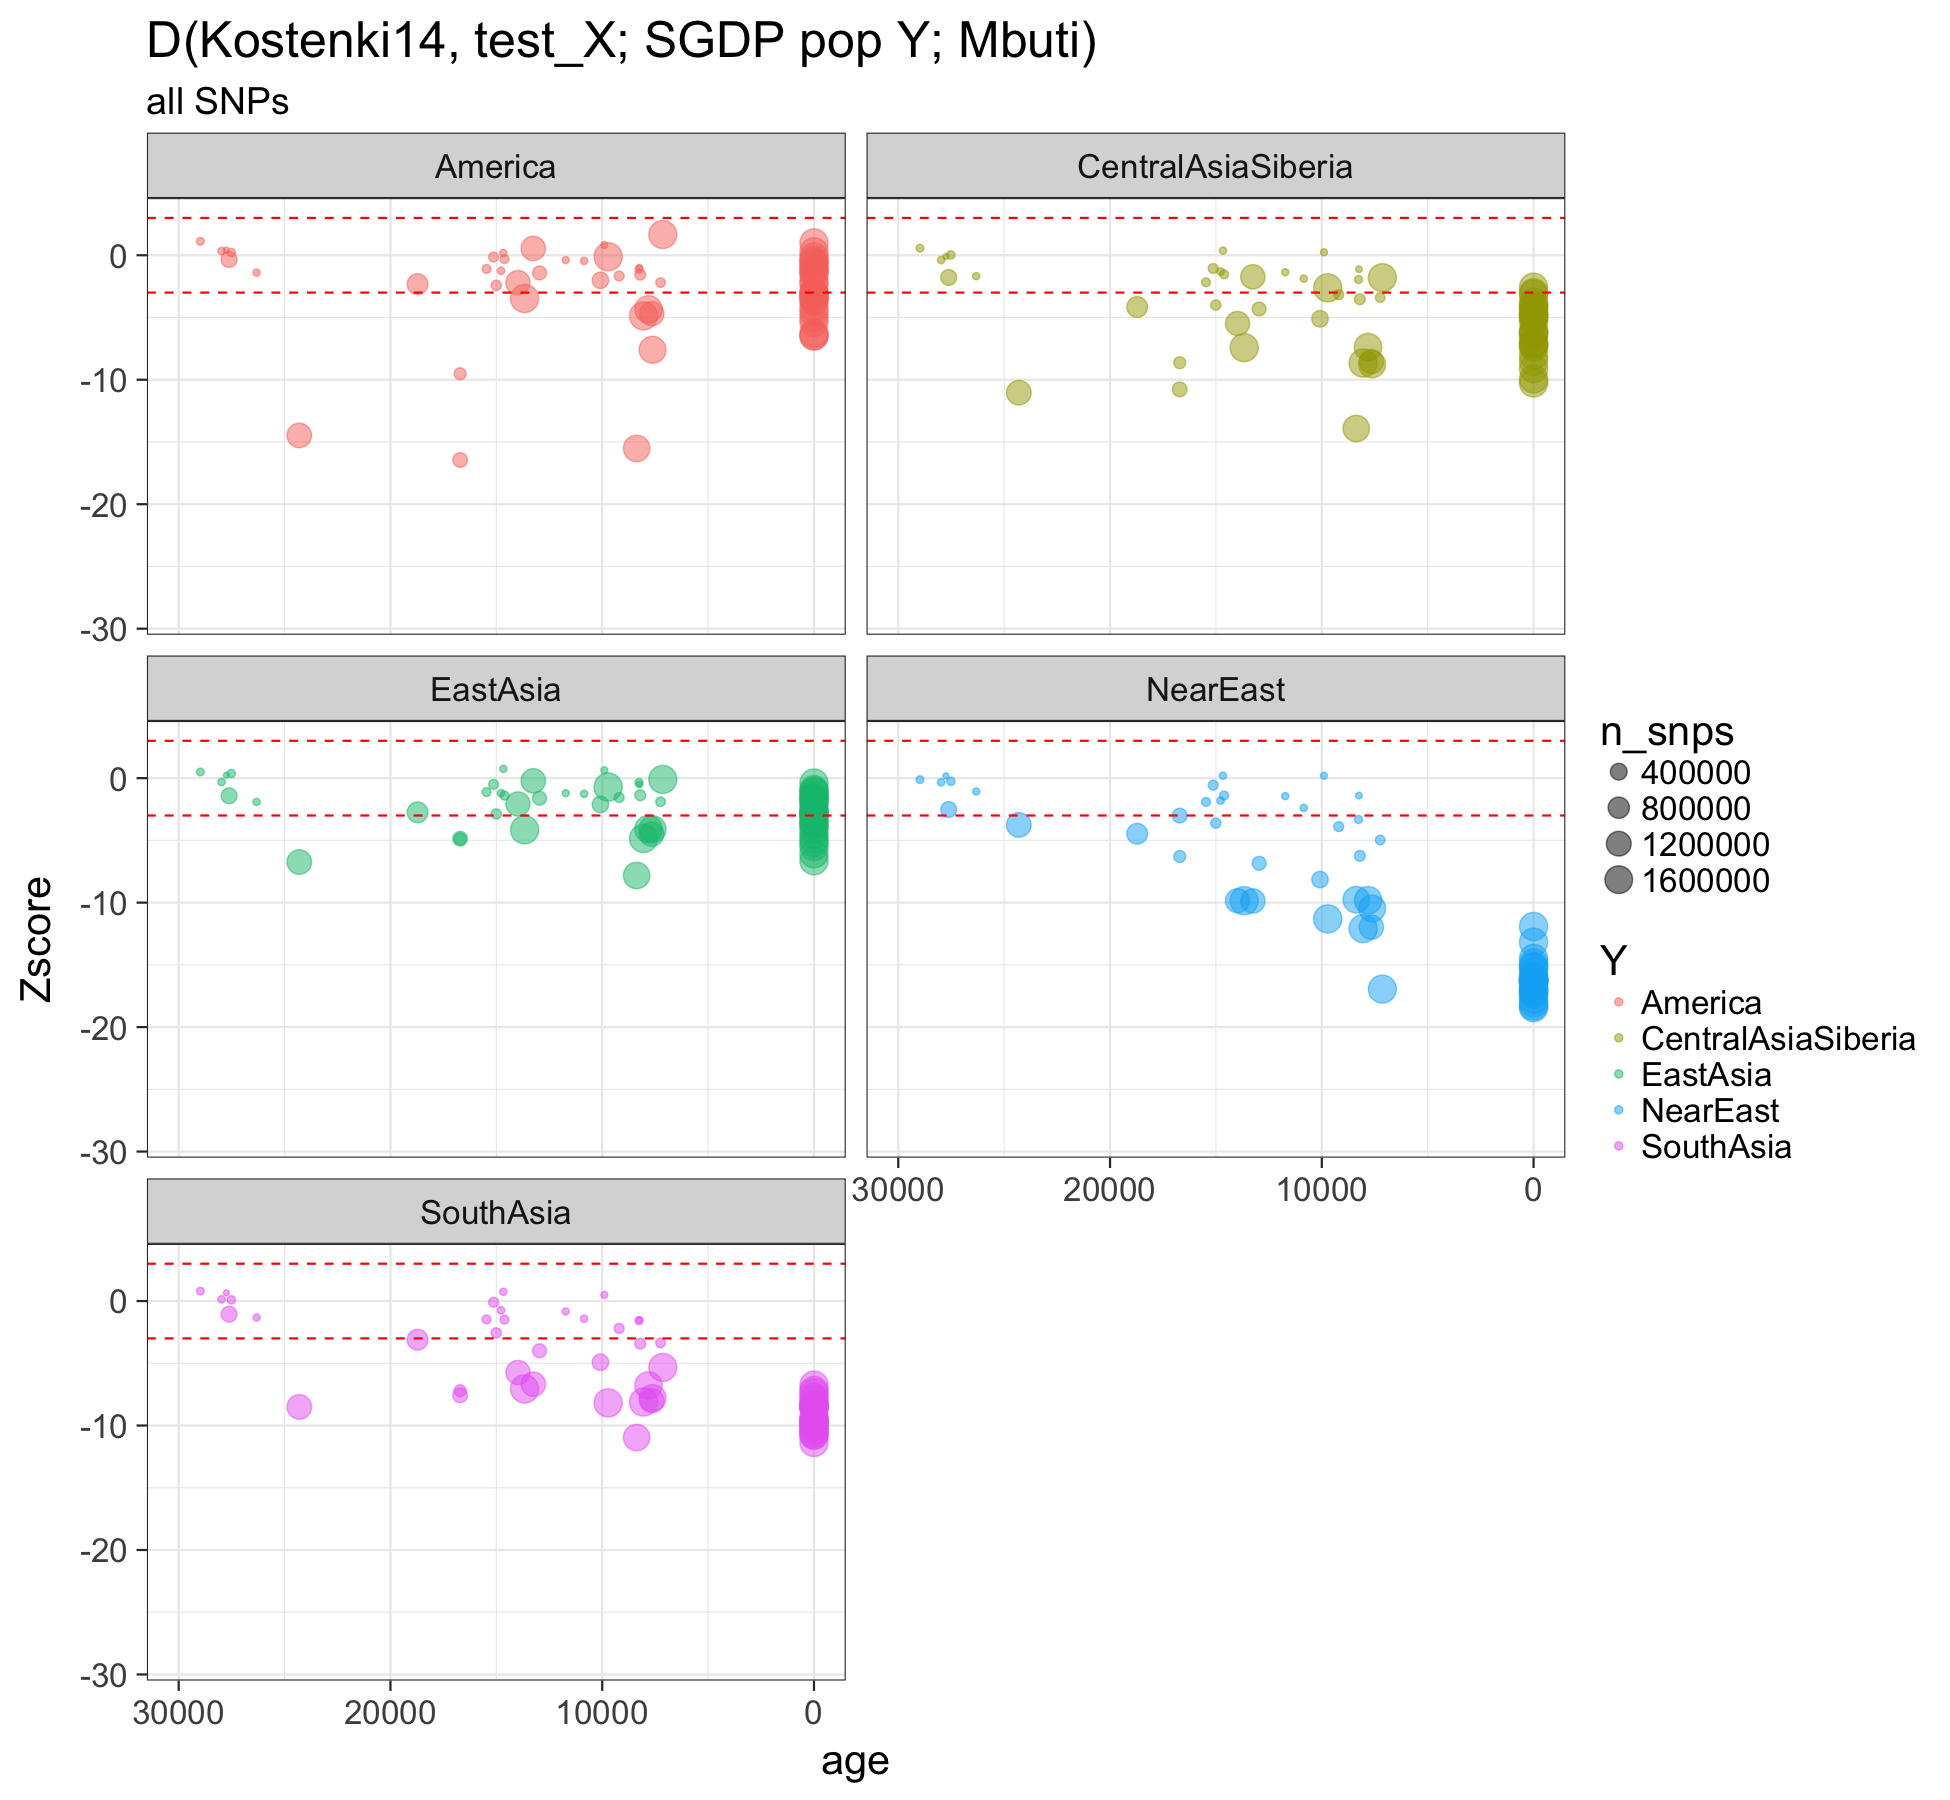

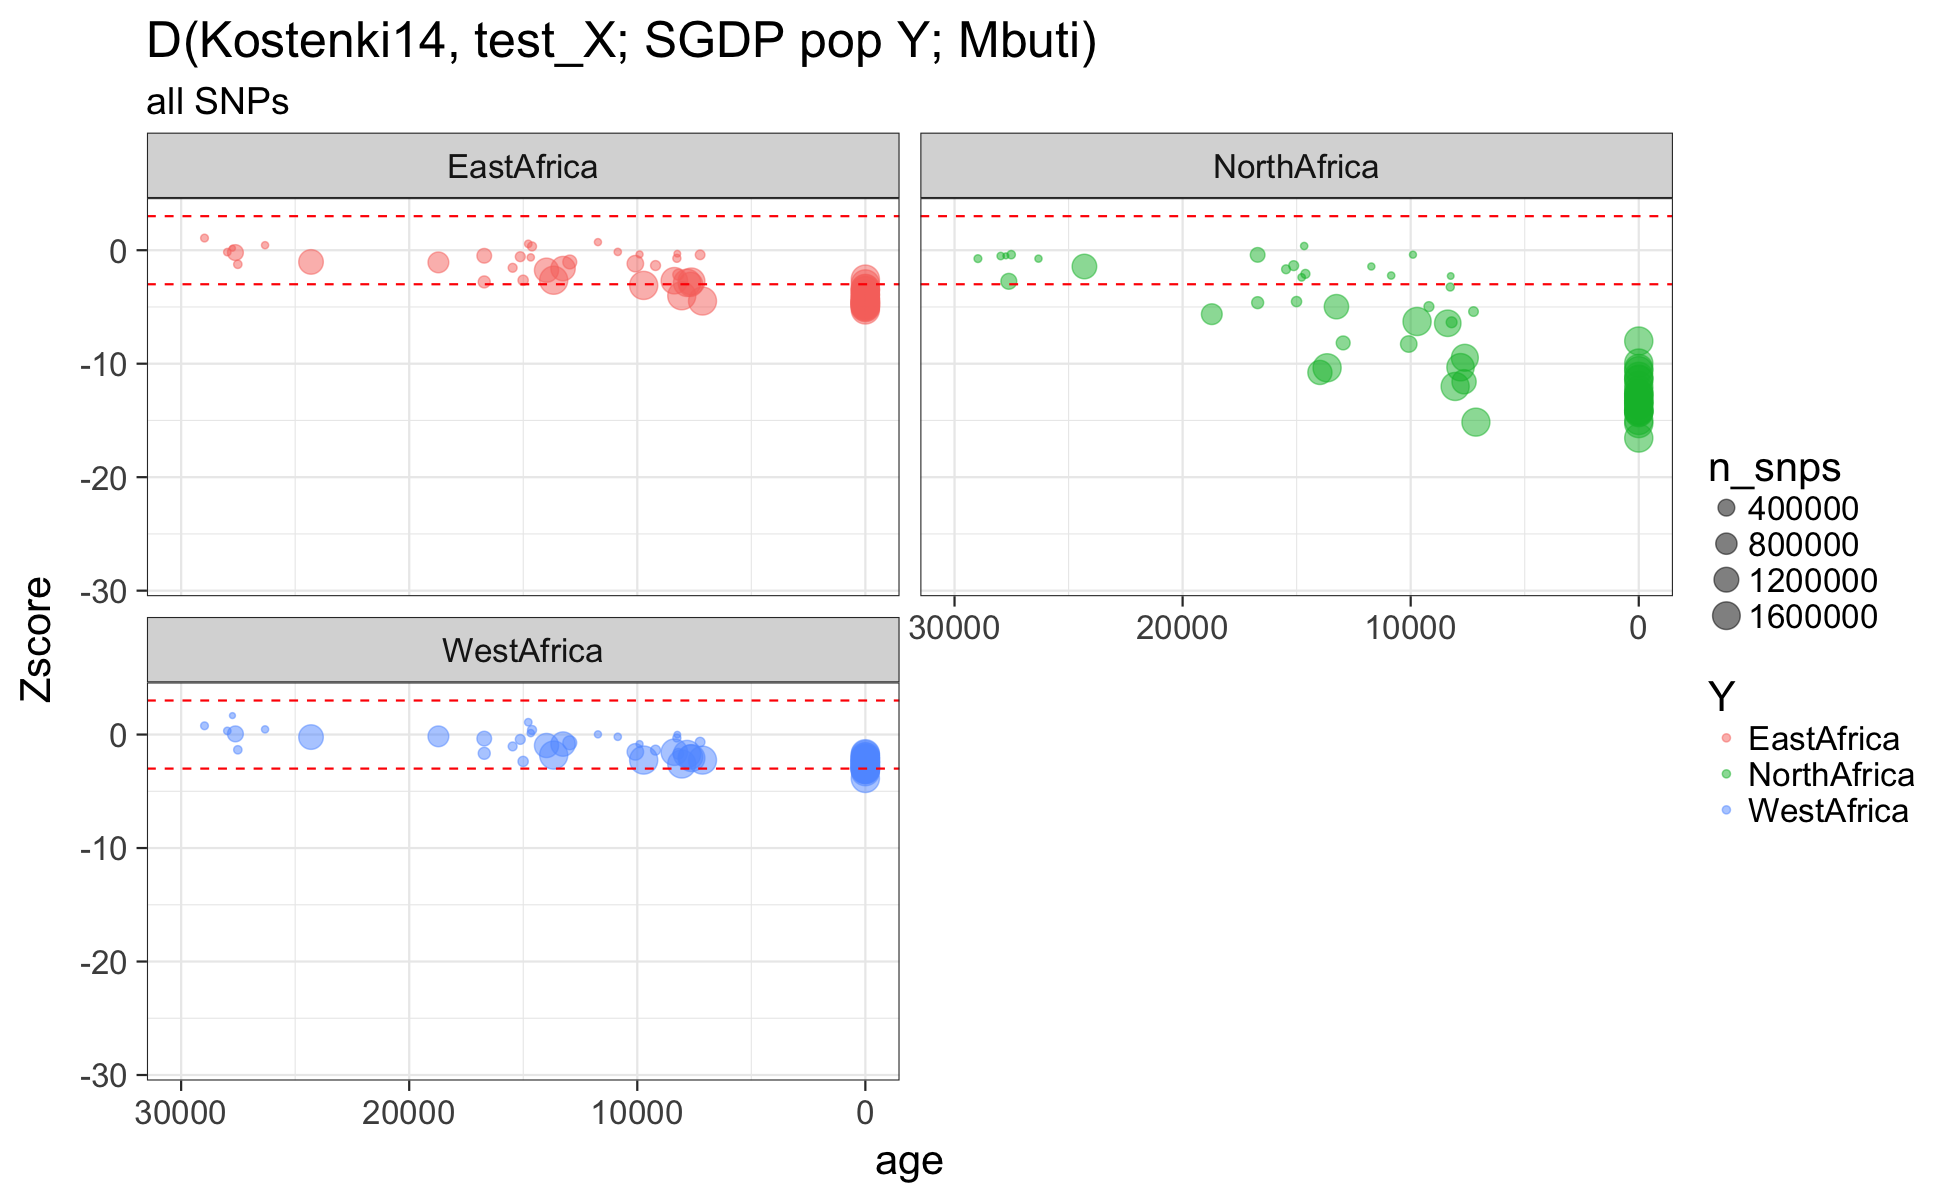

In [236]:
set_dim(8, 5, 150)
filter(df_affinity_mbuti, Y == "Oceania") %>% plot_z

set_dim(13, 12, 150)
filter(df_affinity_mbuti, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_z

set_dim(13, 8, 150)
filter(df_affinity_mbuti, str_detect(Y, "Africa")) %>% plot_z

### Mbuti outgroup - TV only

In [12]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti_tv <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Mbuti",
                       badsnp=BADSNP_FILE, prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Mbuti",
                      badsnp=BADSNP_FILE, prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti_tv[[pop]] <- bind_rows(ancient, modern)
}

In [203]:
df_affinity_mbuti_tv <- bind_rows(affinity_dstats_mbuti_tv) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="transversion")

Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message:
“Removed 60 rows containing missing values (geom_point).”

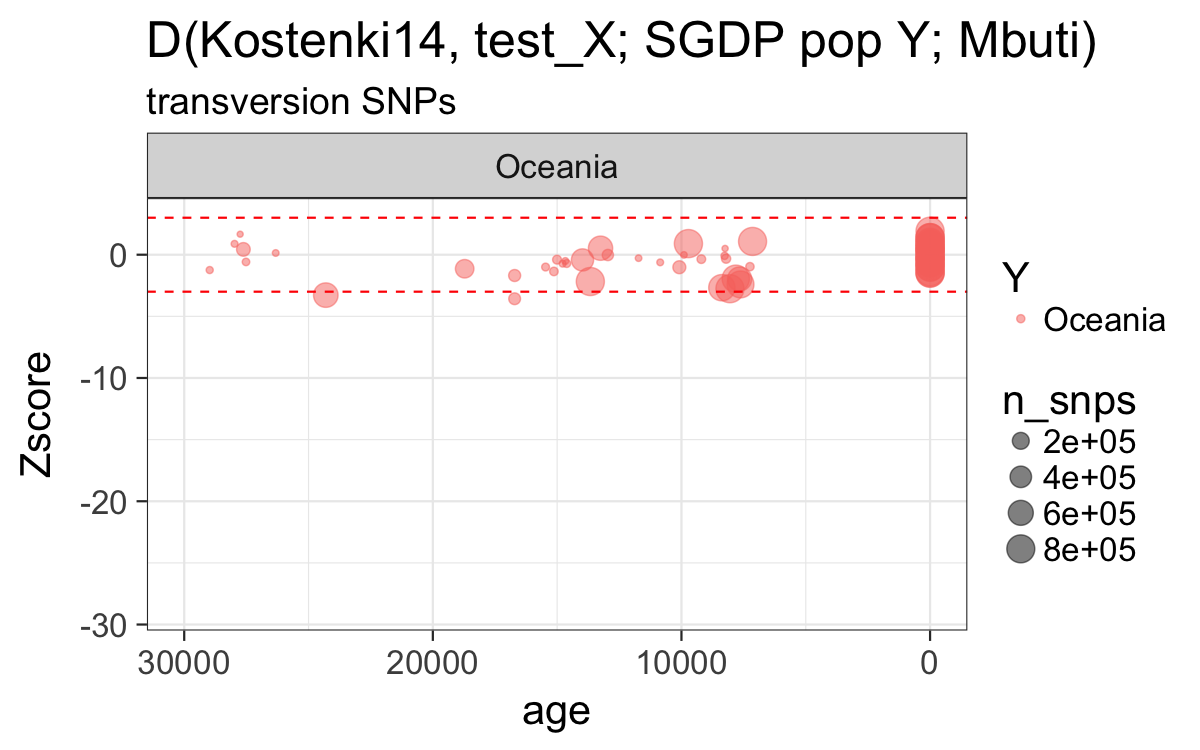

Warning message:
“Removed 36 rows containing missing values (geom_point).”

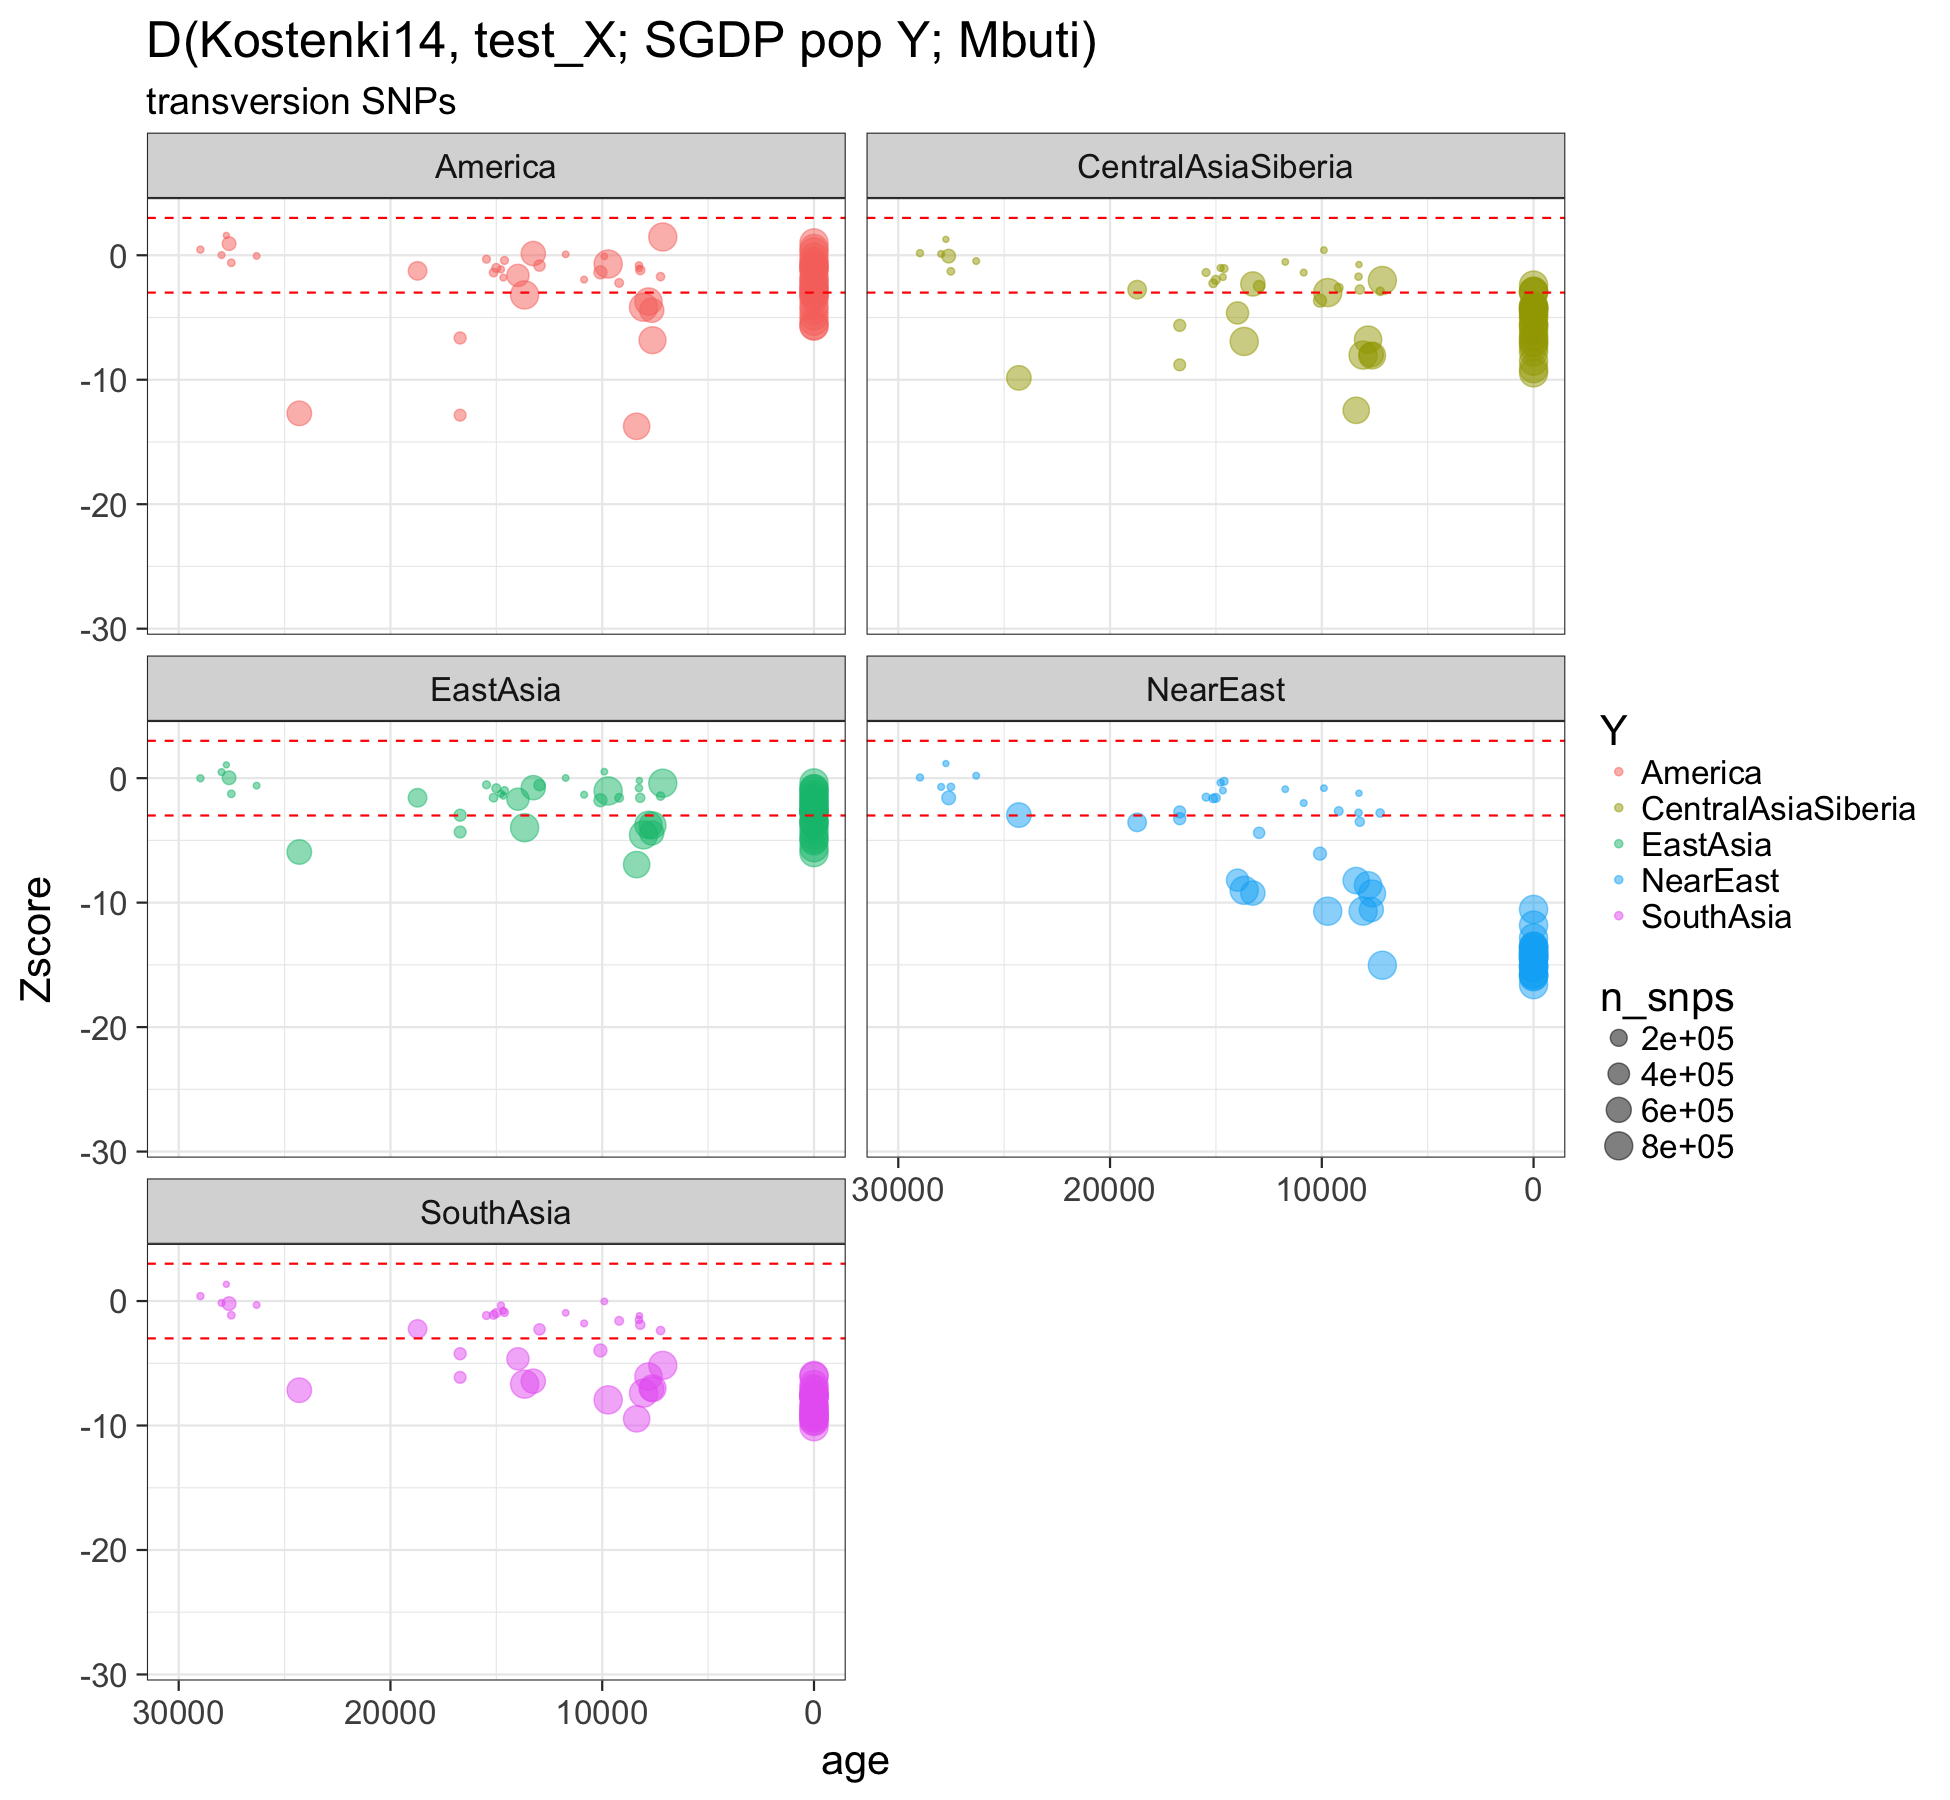

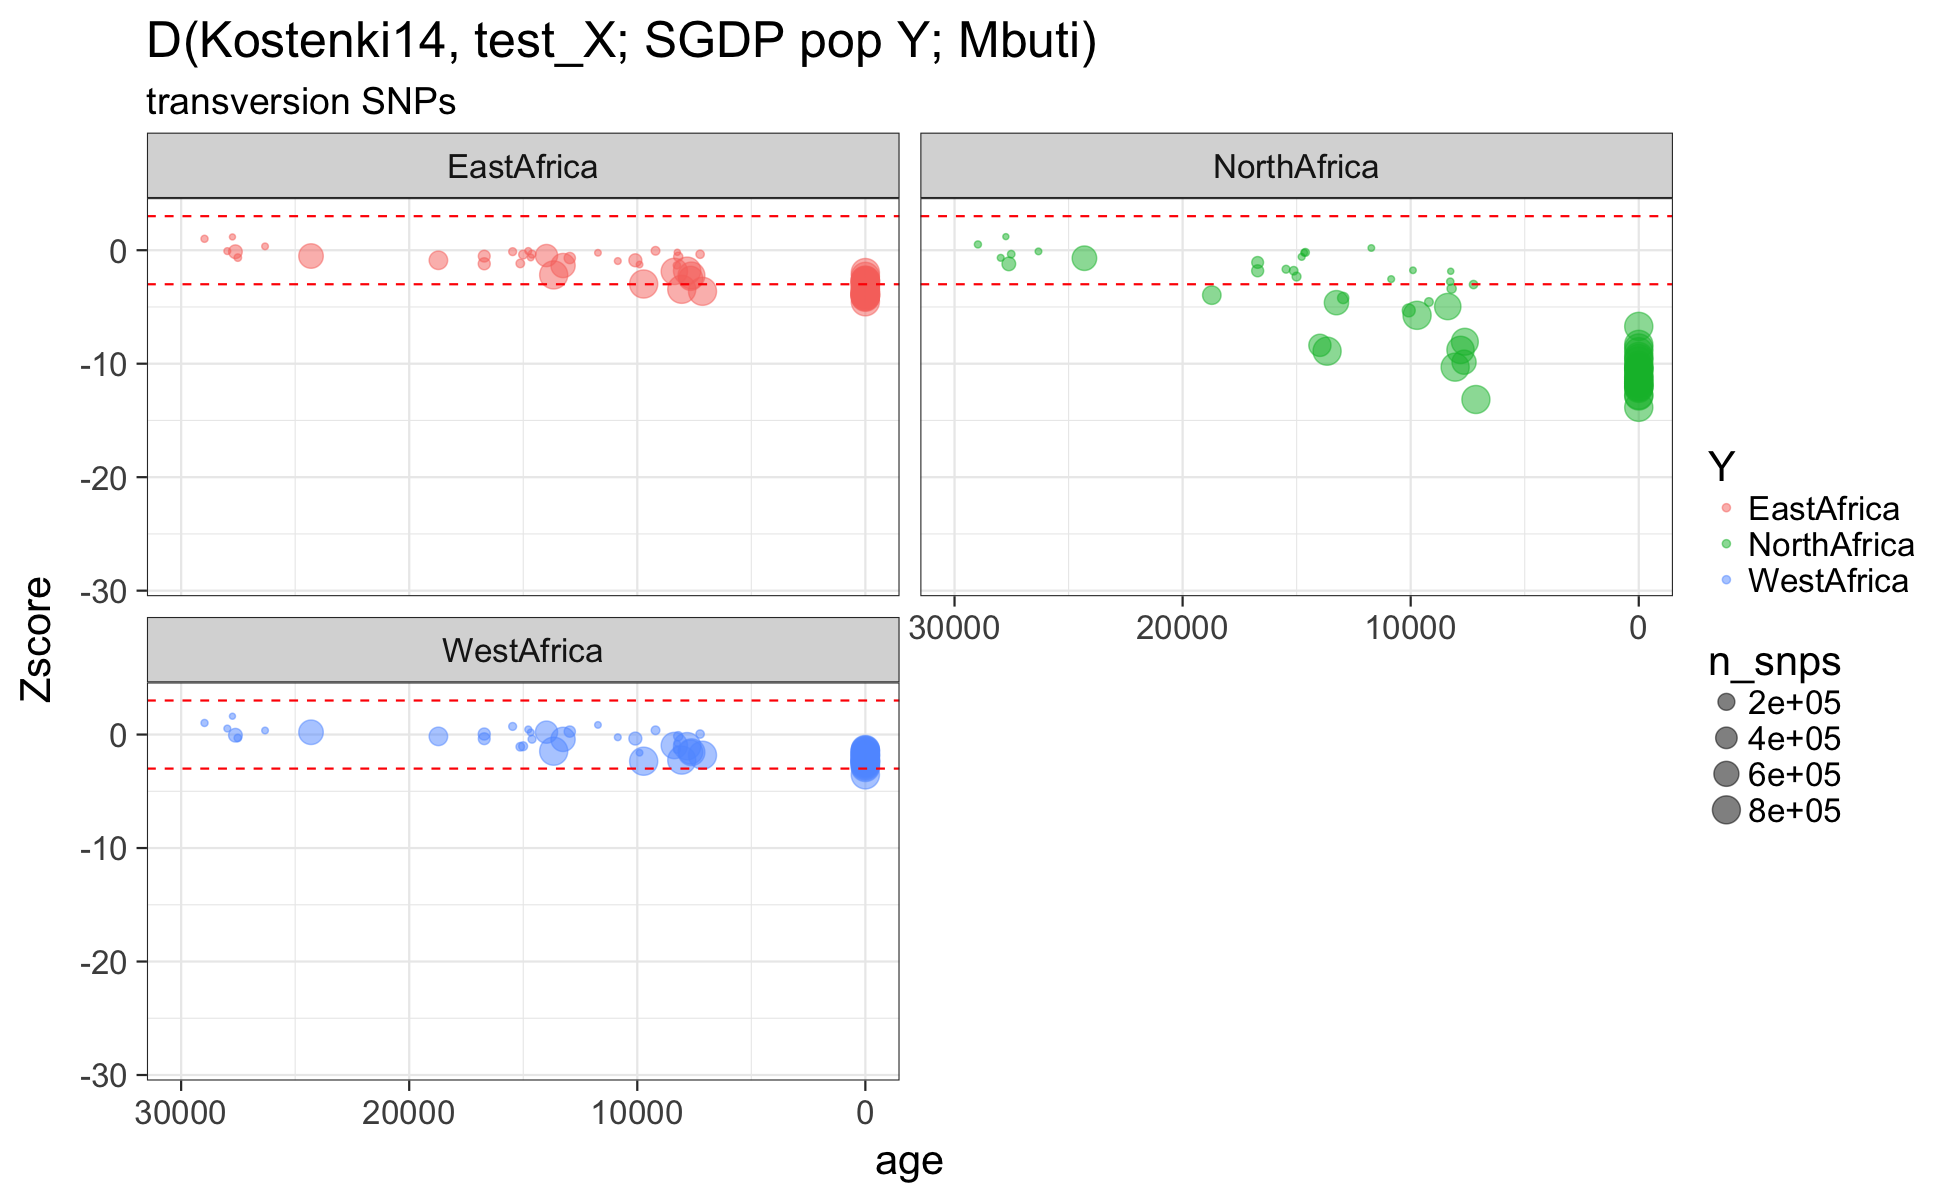

In [237]:
set_dim(8, 5, 150)
filter(df_affinity_mbuti_tv, Y == "Oceania") %>% plot_z

set_dim(13, 12, 150)
filter(df_affinity_mbuti_tv, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_z

set_dim(13, 8, 150)
filter(df_affinity_mbuti_tv, str_detect(Y, "Africa")) %>% plot_z

## Chimp outgroup - all SNPs

In [24]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_affinity"), present_day_Y)

ancient_X <- filter(samples, pop == "EMH", !name %in% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["NearEast"]])$name

In [25]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_chimp <- vector(mode="list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))
    
    affinity_dstats_chimp[[pop]] <- bind_rows(ancient, modern)
}

In [205]:
# join Dstat results for ancient and present-day humans
df_affinity_chimp <- bind_rows(affinity_dstats_chimp) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="all")

Warning message:
“Removed 12 rows containing missing values (geom_point).”

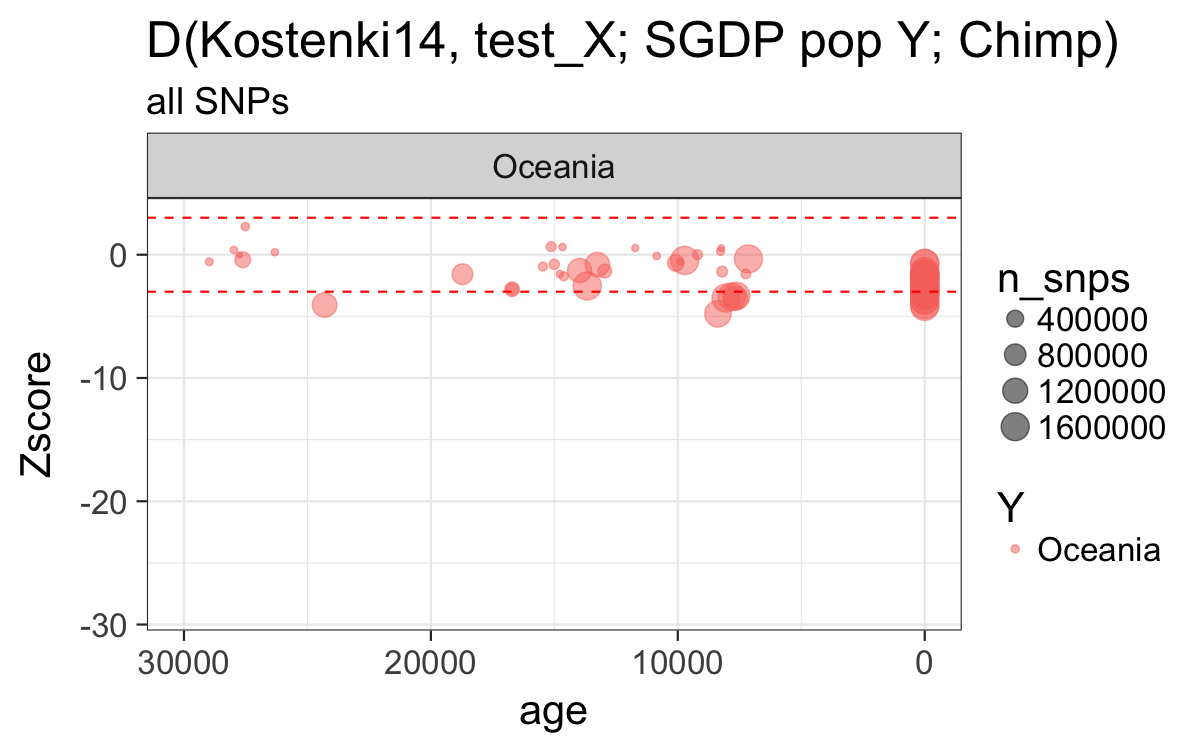

In [239]:
set_dim(8, 5, 150)
filter(df_affinity_chimp, Y == "Oceania") %>% plot_z

# set_dim(13, 12, 150)
# filter(df_affinity_chimp, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_series

# set_dim(13, 8, 150)
# filter(df_affinity_chimp, str_detect(Y, "Africa")) %>% plot_series

Interesting, with Chimp and an outgroup even Oceania shows a weak downward pattern. But this must be clearly an artifact of the data/statistic. No reason present-day Europeans to show evidence of admixture with Oceanians.

Could this be because of an excess damage in Kostenki 14? There is a long branch to chimp, and the other two populations are modern (at least the present-day ones are). Maybe Kostenki14 "shares" more alleles with Chimp because of false substitutions due to damage?

Let's test this on transversions only.

Alternatively, using UstIshim might work too (this sample should have only a limited amount of damage).

### Chimp outgroup - TV only

In [32]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_chimp_tv <- vector(mode="list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"),
                       badsnp=BADSNP_FILE, dir_name="../admixtools/")

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"),
                      badsnp=BADSNP_FILE, dir_name="../admixtools/")
    
    affinity_dstats_chimp_tv[[pop]] <- bind_rows(ancient, modern)
}

In [208]:
# join Dstat results for ancient and present-day humans
df_affinity_chimp_tv <- bind_rows(affinity_dstats_chimp_tv) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="transversion")

Warning message:
“Removed 12 rows containing missing values (geom_point).”

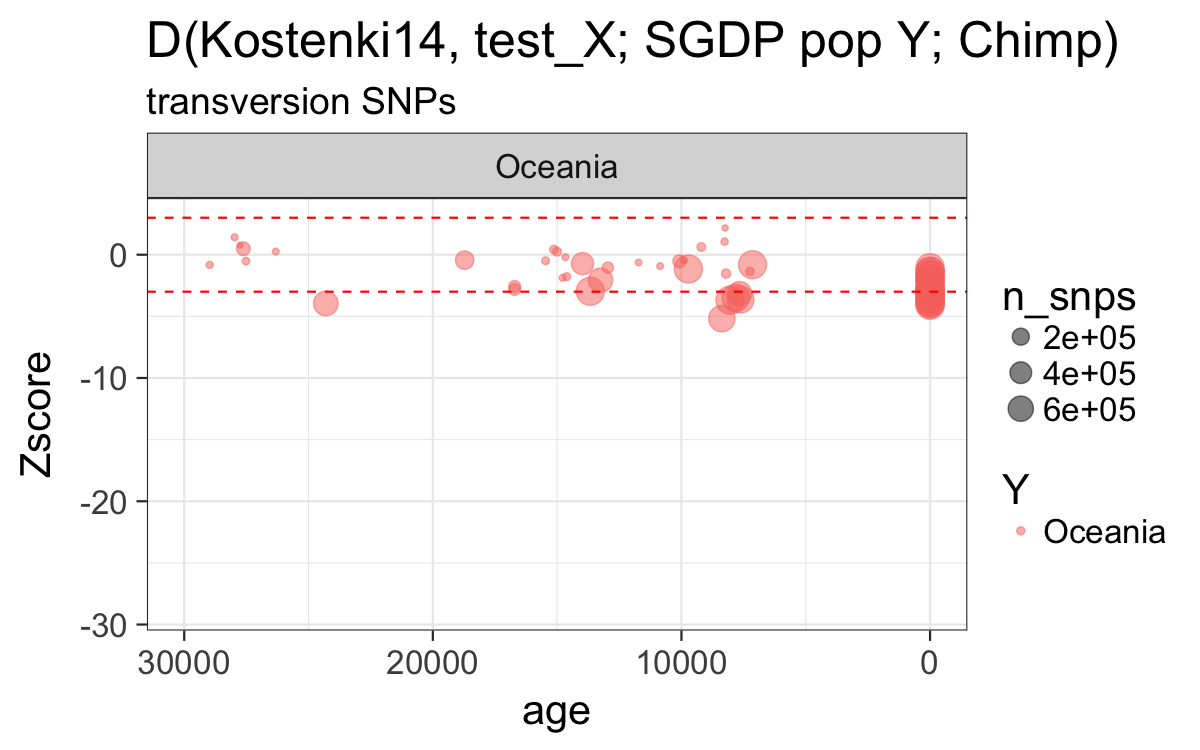

In [241]:
set_dim(8, 5, 150)
filter(df_affinity_chimp_tv, Y == "Oceania") %>% plot_z

# set_dim(13, 12, 150)
# filter(df_affinity_chimp, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_series

# set_dim(13, 8, 150)
# filter(df_affinity_chimp, str_detect(Y, "Africa")) %>% plot_series

So, even TV only leads to a downward pattern of D statistics for Oceanians (which are supposed to be symmetrical).

It must be the "attraction" of Kostenki14 to Chimp, due to a longer branch.

$D(\textrm{Kostenki14}, \textrm{X}; \textrm{present-day population}, \textrm{Mbuti})$

$D = \frac{ABBA - BABA}{ABBA + BABA}$

Let's try with Ust-Ishim instead of Kostenki14 then.

## Ust-Ishim instead of Kostenki14 with Chimp as an outgroup

In [72]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_chimp_ui <- vector(mode="list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity"))
    
    affinity_dstats_chimp_ui[[pop]] <- bind_rows(ancient, modern)
}

In [210]:
# join Dstat results for ancient and present-day humans
df_affinity_chimp_ui <- bind_rows(affinity_dstats_chimp_ui) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="all")

Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message:
“Removed 60 rows containing missing values (geom_point).”

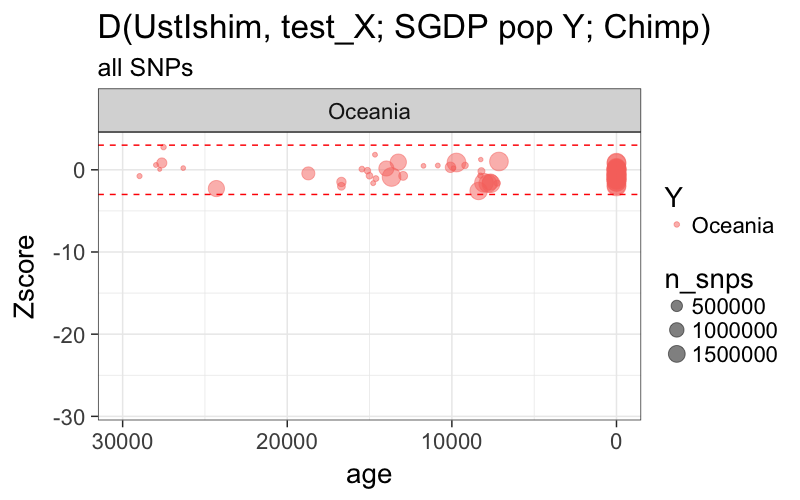

Warning message:
“Removed 48 rows containing missing values (geom_point).”

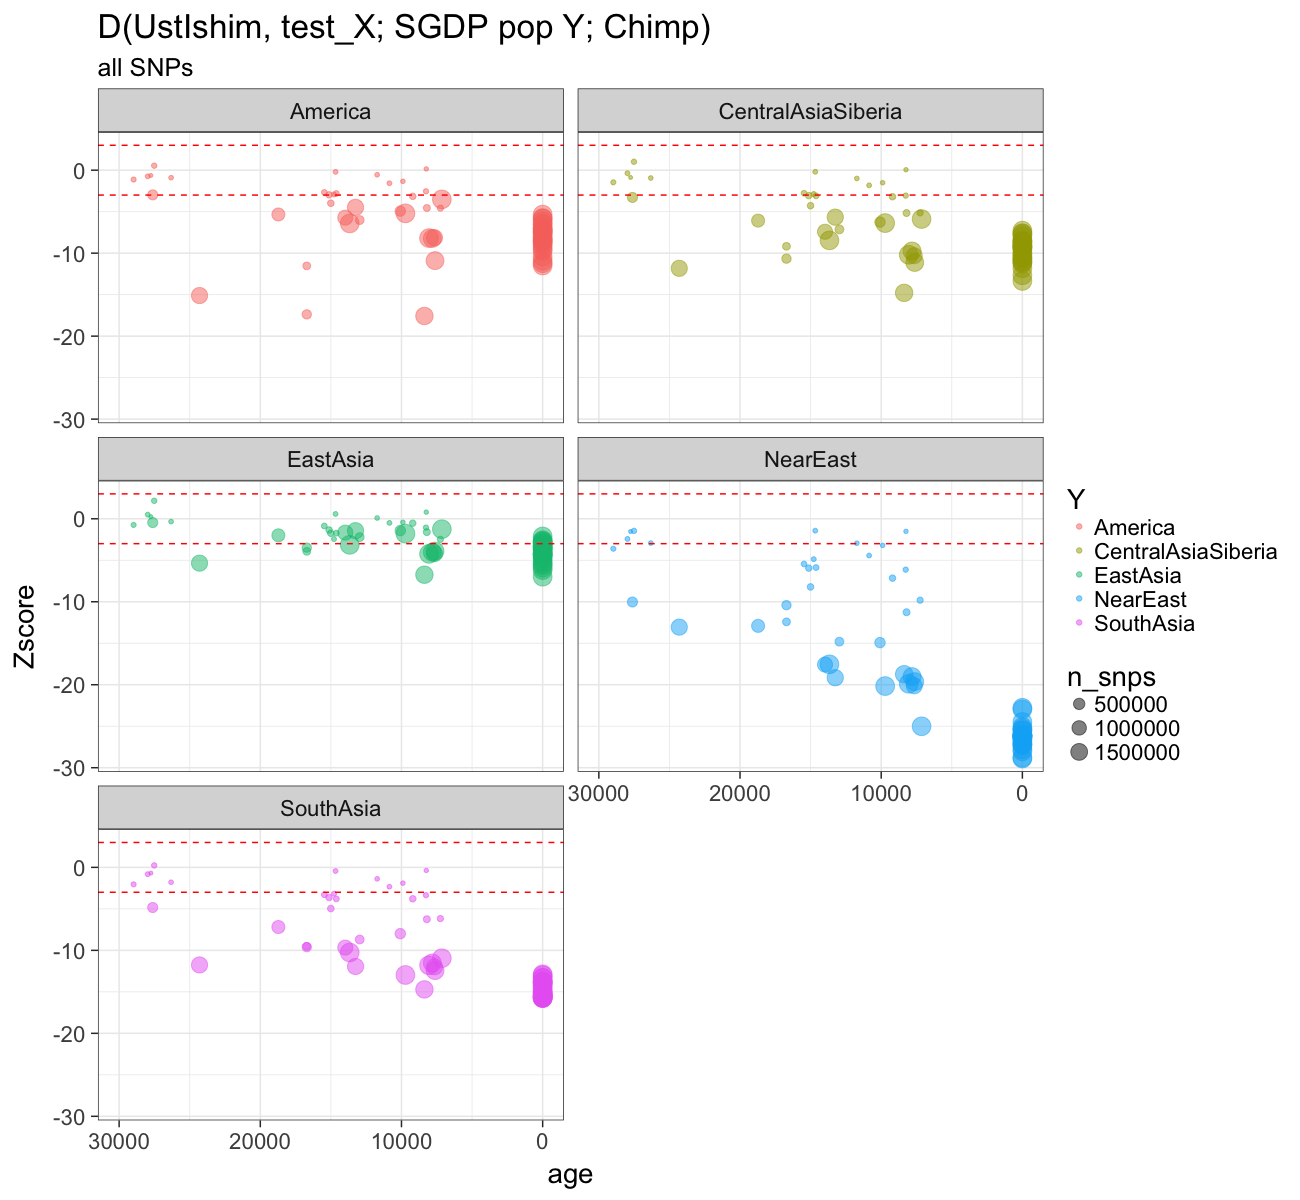

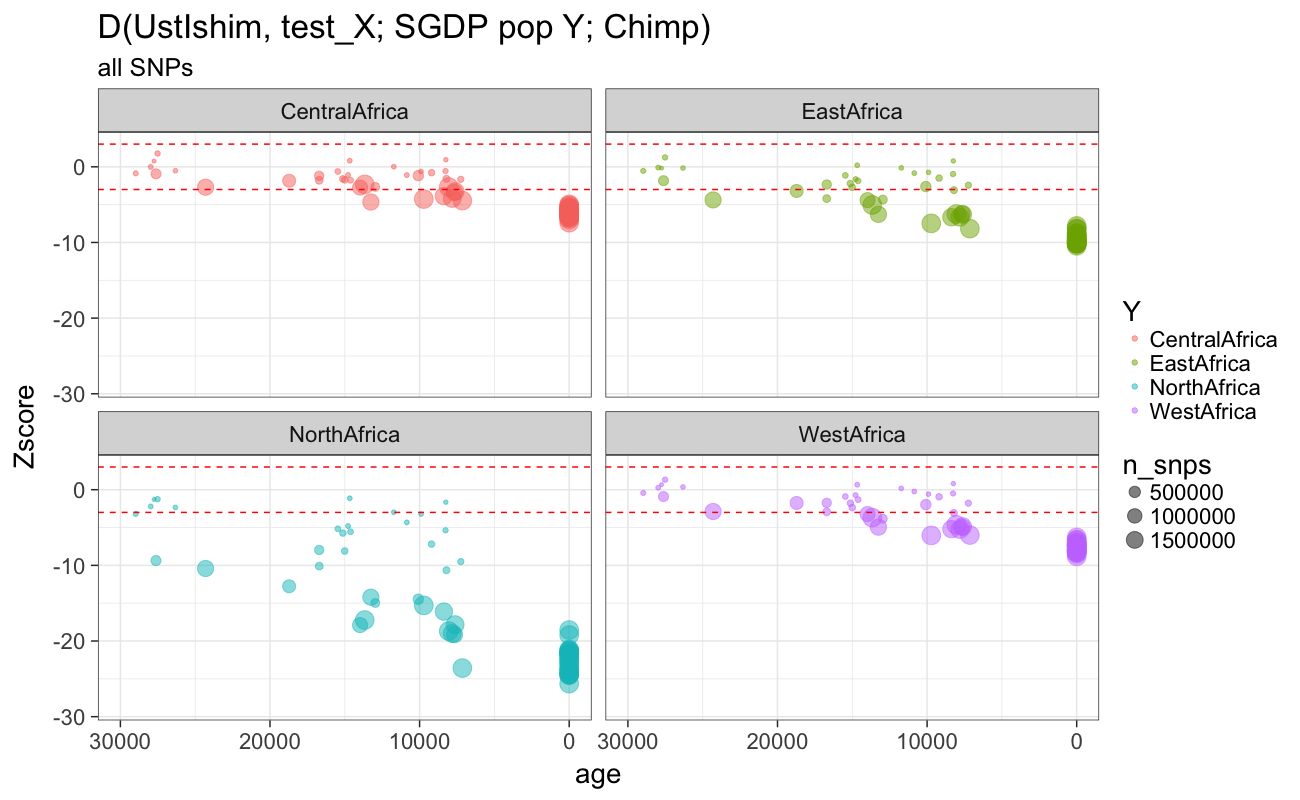

In [249]:
set_dim(8, 5, 100)
filter(df_affinity_chimp_ui, Y == "Oceania") %>% plot_z

set_dim(13, 12, 100)
filter(df_affinity_chimp_ui, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_z

set_dim(13, 8, 100)
filter(df_affinity_chimp_ui, str_detect(Y, "Africa")) %>% plot_z

## Ust-Ishim instead of Kostenki14 with Mbuti as an outgroup

In [78]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)

In [79]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti_ui <- vector(mode="list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Mbuti",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Mbuti",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti_ui[[pop]] <- bind_rows(ancient, modern)
}

In [212]:
# join Dstat results for ancient and present-day humans
df_affinity_mbuti_ui <- bind_rows(affinity_dstats_mbuti_ui) %>% inner_join(samples, by=c("X"="name")) %>% mutate(set="all")

Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 64 rows containing missing values (geom_point).”

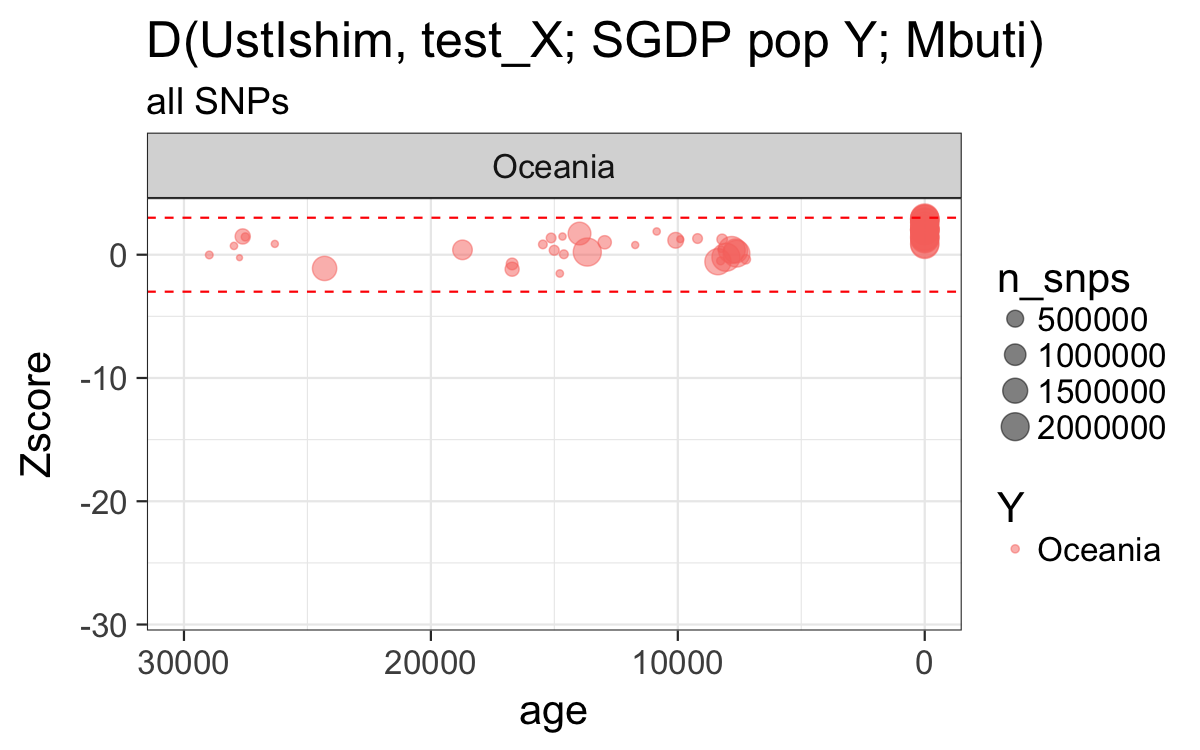

Warning message:
“Removed 36 rows containing missing values (geom_point).”

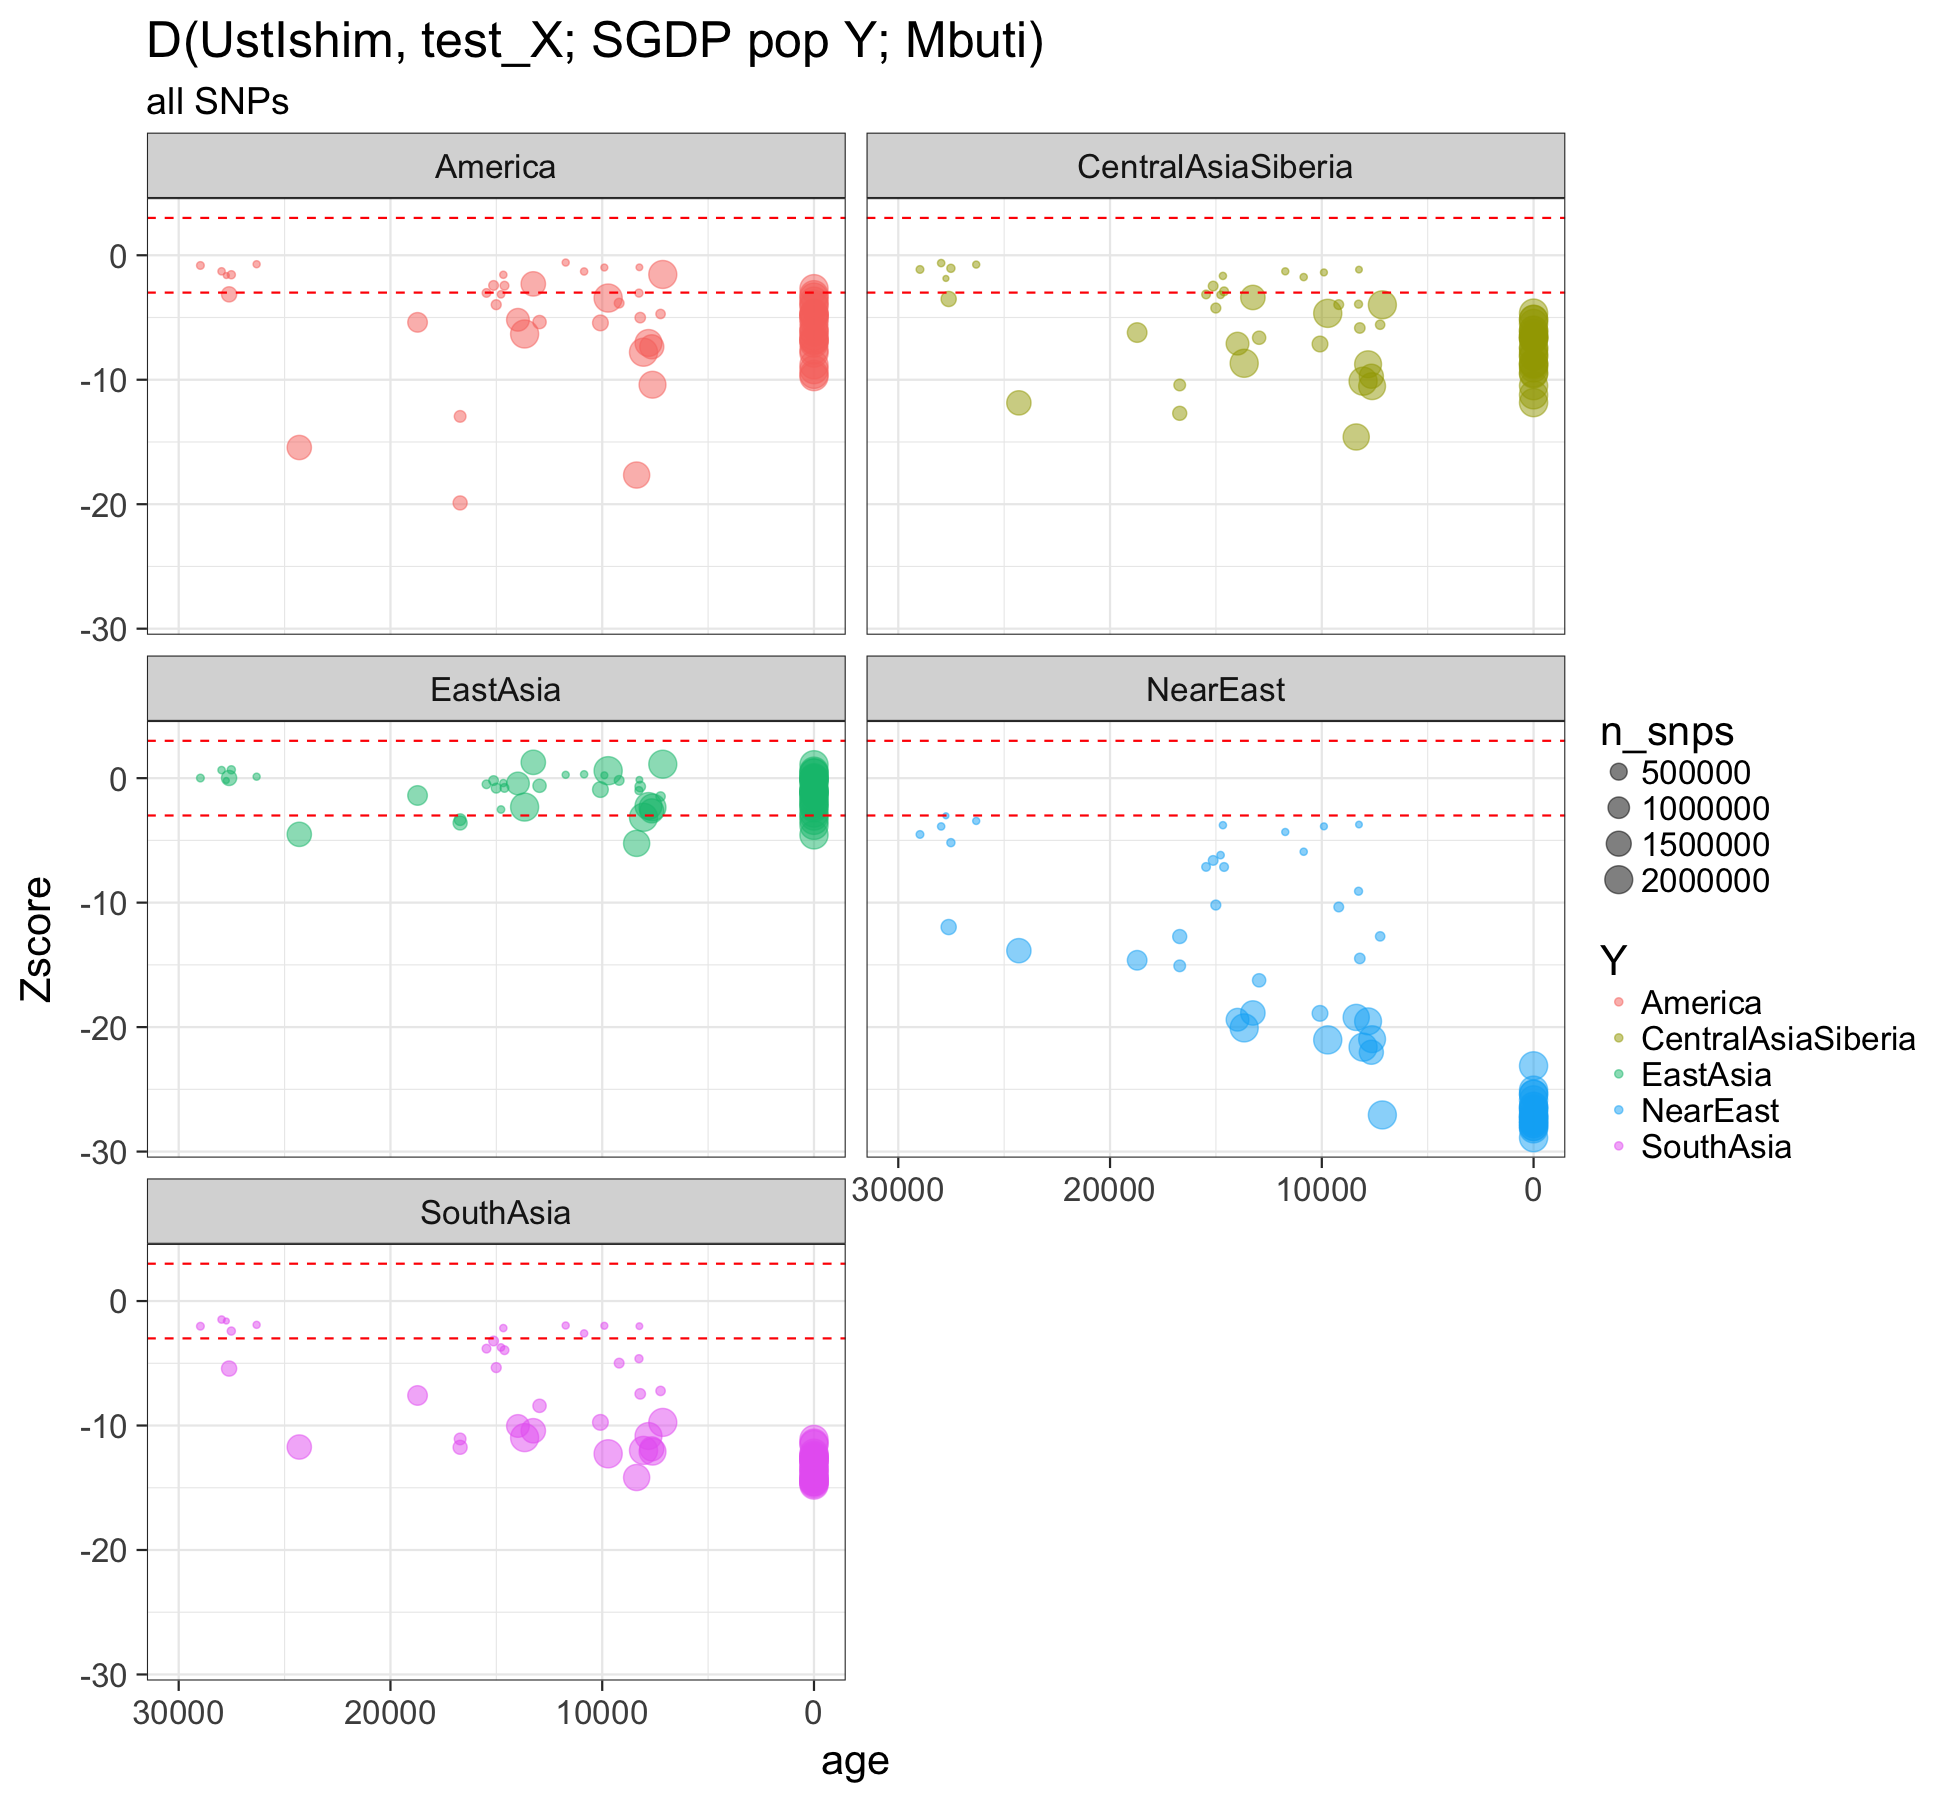

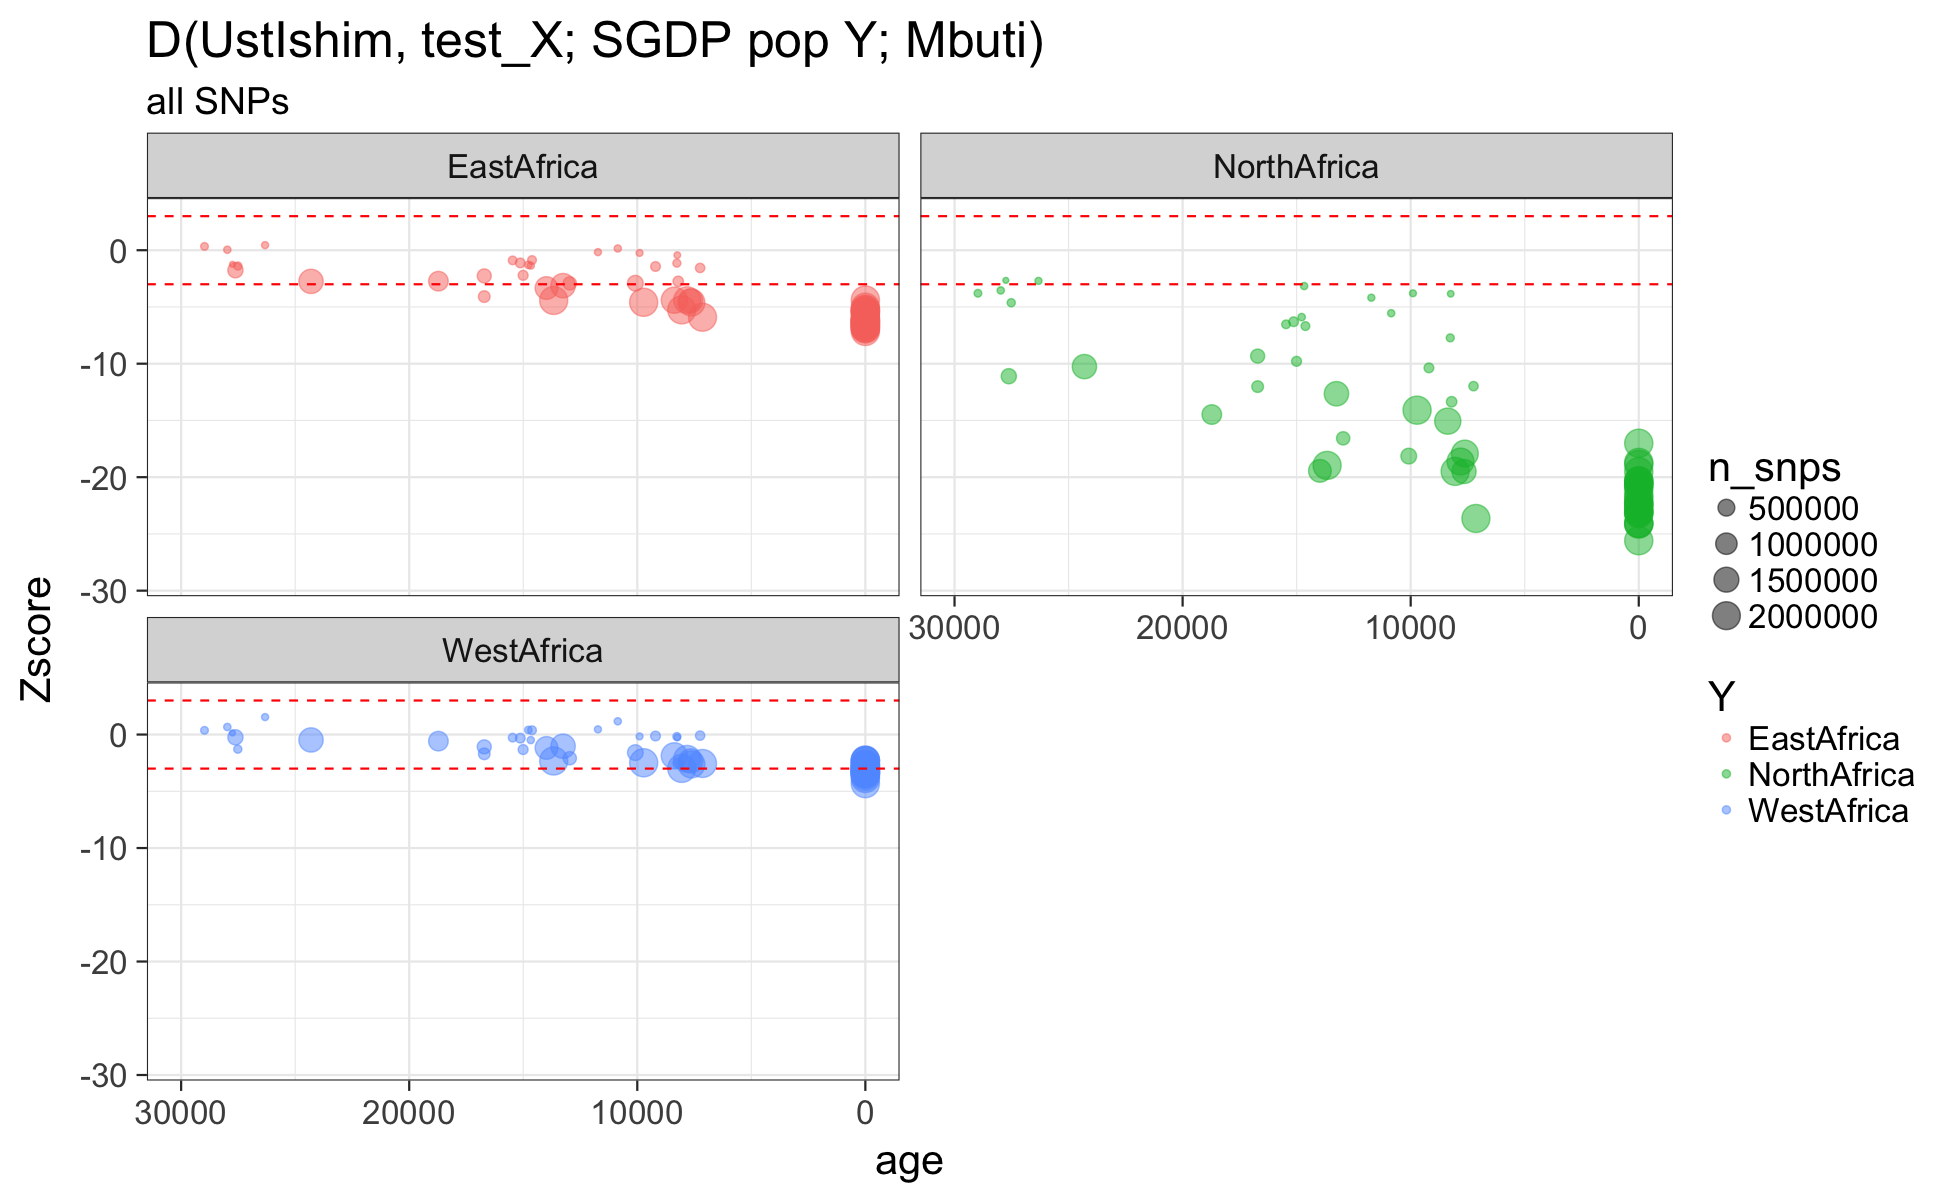

In [243]:
set_dim(8, 5, 150)
filter(df_affinity_mbuti_ui, Y == "Oceania") %>% plot_series

set_dim(13, 12, 150)
filter(df_affinity_mbuti_ui, !str_detect(Y, "Africa"), Y != "Oceania") %>% plot_series

set_dim(13, 8, 150)
filter(df_affinity_mbuti_ui, str_detect(Y, "Africa")) %>% plot_series

# Testing that central/west Afr. are outgroup to east Afr. + non-Africans

Ben had the following idea:

$D(\textrm{non-Afr},\textrm{Dinka},\textrm{west-or-centra-or-north-Afr},\textrm{Chimp})$

I tested that using all East Africans except Masai and Somali, which I excluded because of evidence of non-African admixture into east Africans (see [here](http://www.cell.com/cms/attachment/2108833685/2082649541/mmc6.xlsx) and also bellow). Otherwise the D(non-Afr, East Africa; Central Africa, Chimp) is obviously affected, because non-Africans and East Africans are drawn together (making the D go closer to 0).

In [632]:
africans <- list(
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Luhya", "Luo") # excluded "Masai", "Somali" (non-African backflow) - Table S6 in Pontus et al.
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_Africans"), africans)

ancient_X <- filter(samples, pop == "EMH")$name
modern_X <- filter(samples, pop == "WestEurasia")$name

## all SNPs

In [481]:
africans_dstats <- vector(mode="list")
for (pop in c("WestAfrica", "CentralAfrica")) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W=ancient_X, X="EastAfrica", Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W=modern_X, X="EastAfrica", Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans"))
    
    africans_dstats[[pop]] <- bind_rows(ancient, modern)
}

### modern West Eurasians

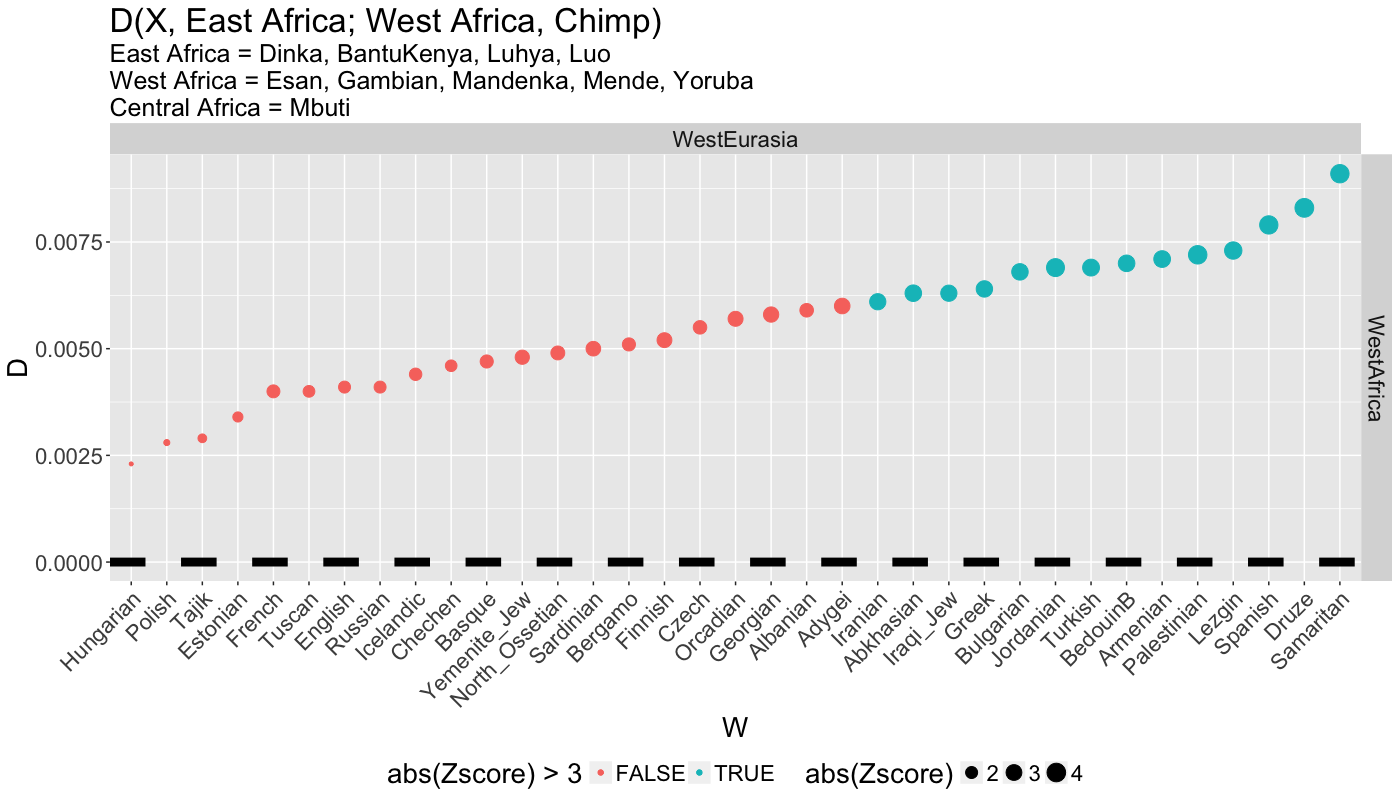

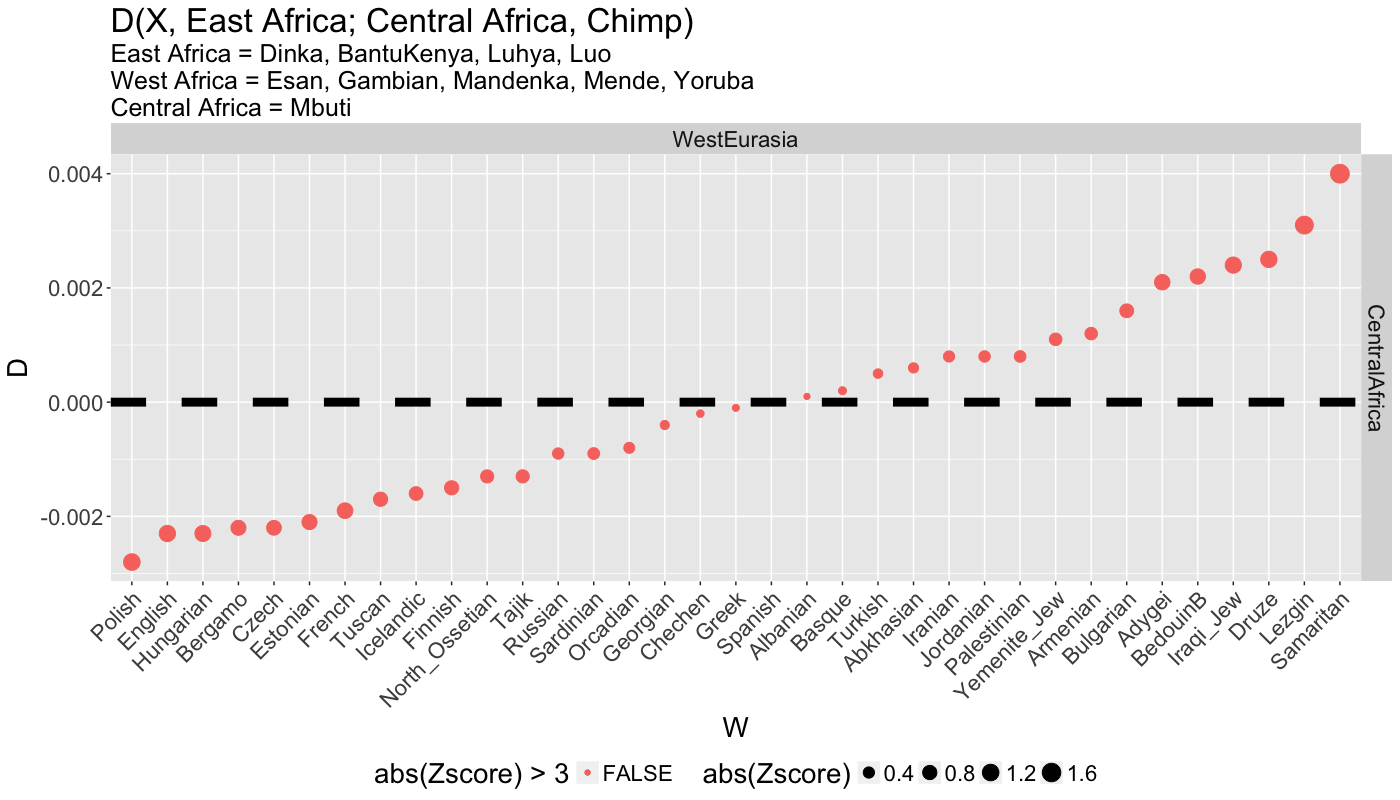

In [483]:
set_dim(14, 8, 100)

bind_rows(africans_dstats) %>% inner_join(samples, by=c("W"="name")) %>%
filter(pop == "WestEurasia", Y == "WestAfrica") %>% 
mutate(stderr=D/Zscore, W=factor(W, levels=W[order(D)])) %>% 
ggplot(aes(W, D)) +
    geom_point(aes(size=abs(Zscore), color=abs(Zscore) > 3)) +
#    geom_errorbar(aes(ymin=D - stderr, ymax=D + stderr), width=0.25) +
    geom_hline(yintercept=0, linetype=2, size=3) +
    facet_grid(Y ~ pop, scales="free_x") +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          text=element_text(size=20),
          legend.position="bottom") +
    ggtitle(paste0("D(X, East Africa; West Africa, Chimp)"),
            "East Africa = Dinka, BantuKenya, Luhya, Luo\nWest Africa = Esan, Gambian, Mandenka, Mende, Yoruba
Central Africa = Mbuti")

set_dim(14, 8, 100)

bind_rows(africans_dstats) %>% inner_join(samples, by=c("W"="name")) %>%
filter(pop == "WestEurasia", Y == "CentralAfrica") %>% 
mutate(stderr=D/Zscore, W=factor(W, levels=W[order(D)])) %>% 
ggplot(aes(W, D)) +
    geom_point(aes(size=abs(Zscore), color=abs(Zscore) > 3)) +
#    geom_errorbar(aes(ymin=D - stderr, ymax=D + stderr), width=0.25) +
    geom_hline(yintercept=0, linetype=2, size=3) +
    facet_grid(Y ~ pop, scales="free_x") +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          text=element_text(size=20),
          legend.position="bottom") +
    ggtitle(paste0("D(X, East Africa; Central Africa, Chimp)"),
            "East Africa = Dinka, BantuKenya, Luhya, Luo\nWest Africa = Esan, Gambian, Mandenka, Mende, Yoruba
Central Africa = Mbuti")

# TODO How do these plots look like for D(X, West Africa; Central Africa, Chimp)?

Do non-Africans + West Africans also form a clade vs Central Africa?

### EMHs

These didn't make a lot of sense, because there is a huge excess of ABBA sites (because damaged and error-prone EMH samples are artificially drawn to Chimp). I deleted those plots. Can be reproduced by filtering for `pop == "EMH"` using code right above.

# Do central and west Afr. really form a clade, with east Afr. as an outgroup?

This is the basic assumption of the f4 ratio calculation from the Ice Age paper.

$D(\textrm{west African},\textrm{central African},\textrm{east African},\textrm{Chimp})$

In [486]:
wc_vs_east <- qpDstat(W=africans$WestAfrica, X=africans$CentralAfrica, Y=africans$EastAfrica, Z="Chimp", prefix=EIGENSTRAT_PREFIX)

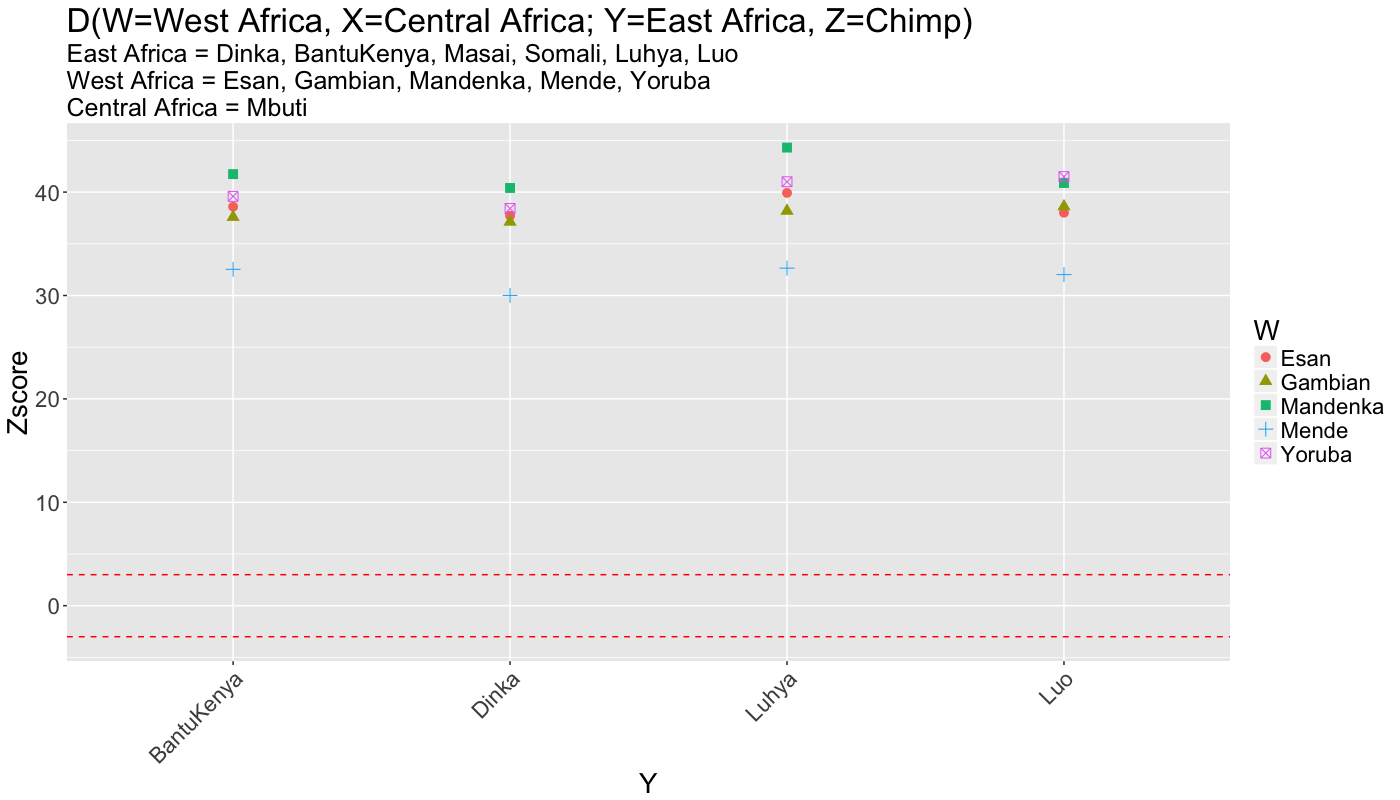

In [487]:
set_dim(14, 8, 100)

wc_vs_east %>%
ggplot(aes(Y, Zscore, shape=W, color=W)) +
    geom_point(size=3) +
    geom_hline(yintercept=c(-3, 3), linetype=2, color="red") +
    theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle(paste0("D(W=West Africa, X=Central Africa; Y=East Africa, Z=Chimp)"),
            "East Africa = Dinka, BantuKenya, Masai, Somali, Luhya, Luo\nWest Africa = Esan, Gambian, Mandenka, Mende, Yoruba
Central Africa = Mbuti")

**Conclusion**: West and Central Africans do **not** form a clade with respect to East Africans! If they were, we would expect D ~ 0. This directly violates the Ice Age f4 ratio assumption!

# Testing Eurasian backflow into Africans

$D(\textrm{Eurasian 1},\textrm{Eurasian 2},\textrm{test African},\textrm{Chimp})$

In [583]:
non_africans <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "Europe"=filter(samples, pop == "WestEurasia", !str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name
)

In [634]:
all_africans <- list(
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite"),
    "CentralAfrica"="Mbuti"
)

In [585]:
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_whole_nonafr_pops"), non_africans)

In [586]:
backflow_dstats <- data.frame()

for (pop1 in names(non_africans)) {
    for (pop2 in setdiff(names(non_africans), pop1)) {
        backflow_dstats <- qpDstat(W=pop1, X=pop2, Y=unlist(all_africans), Z="Chimp",
                                   prefix=EIGENSTRAT_PREFIX,
                                   ind=paste0(IND_FILE, ".SGDP_whole_nonafr_pops")) %>%
                           bind_rows(backflow_dstats)
    }
}

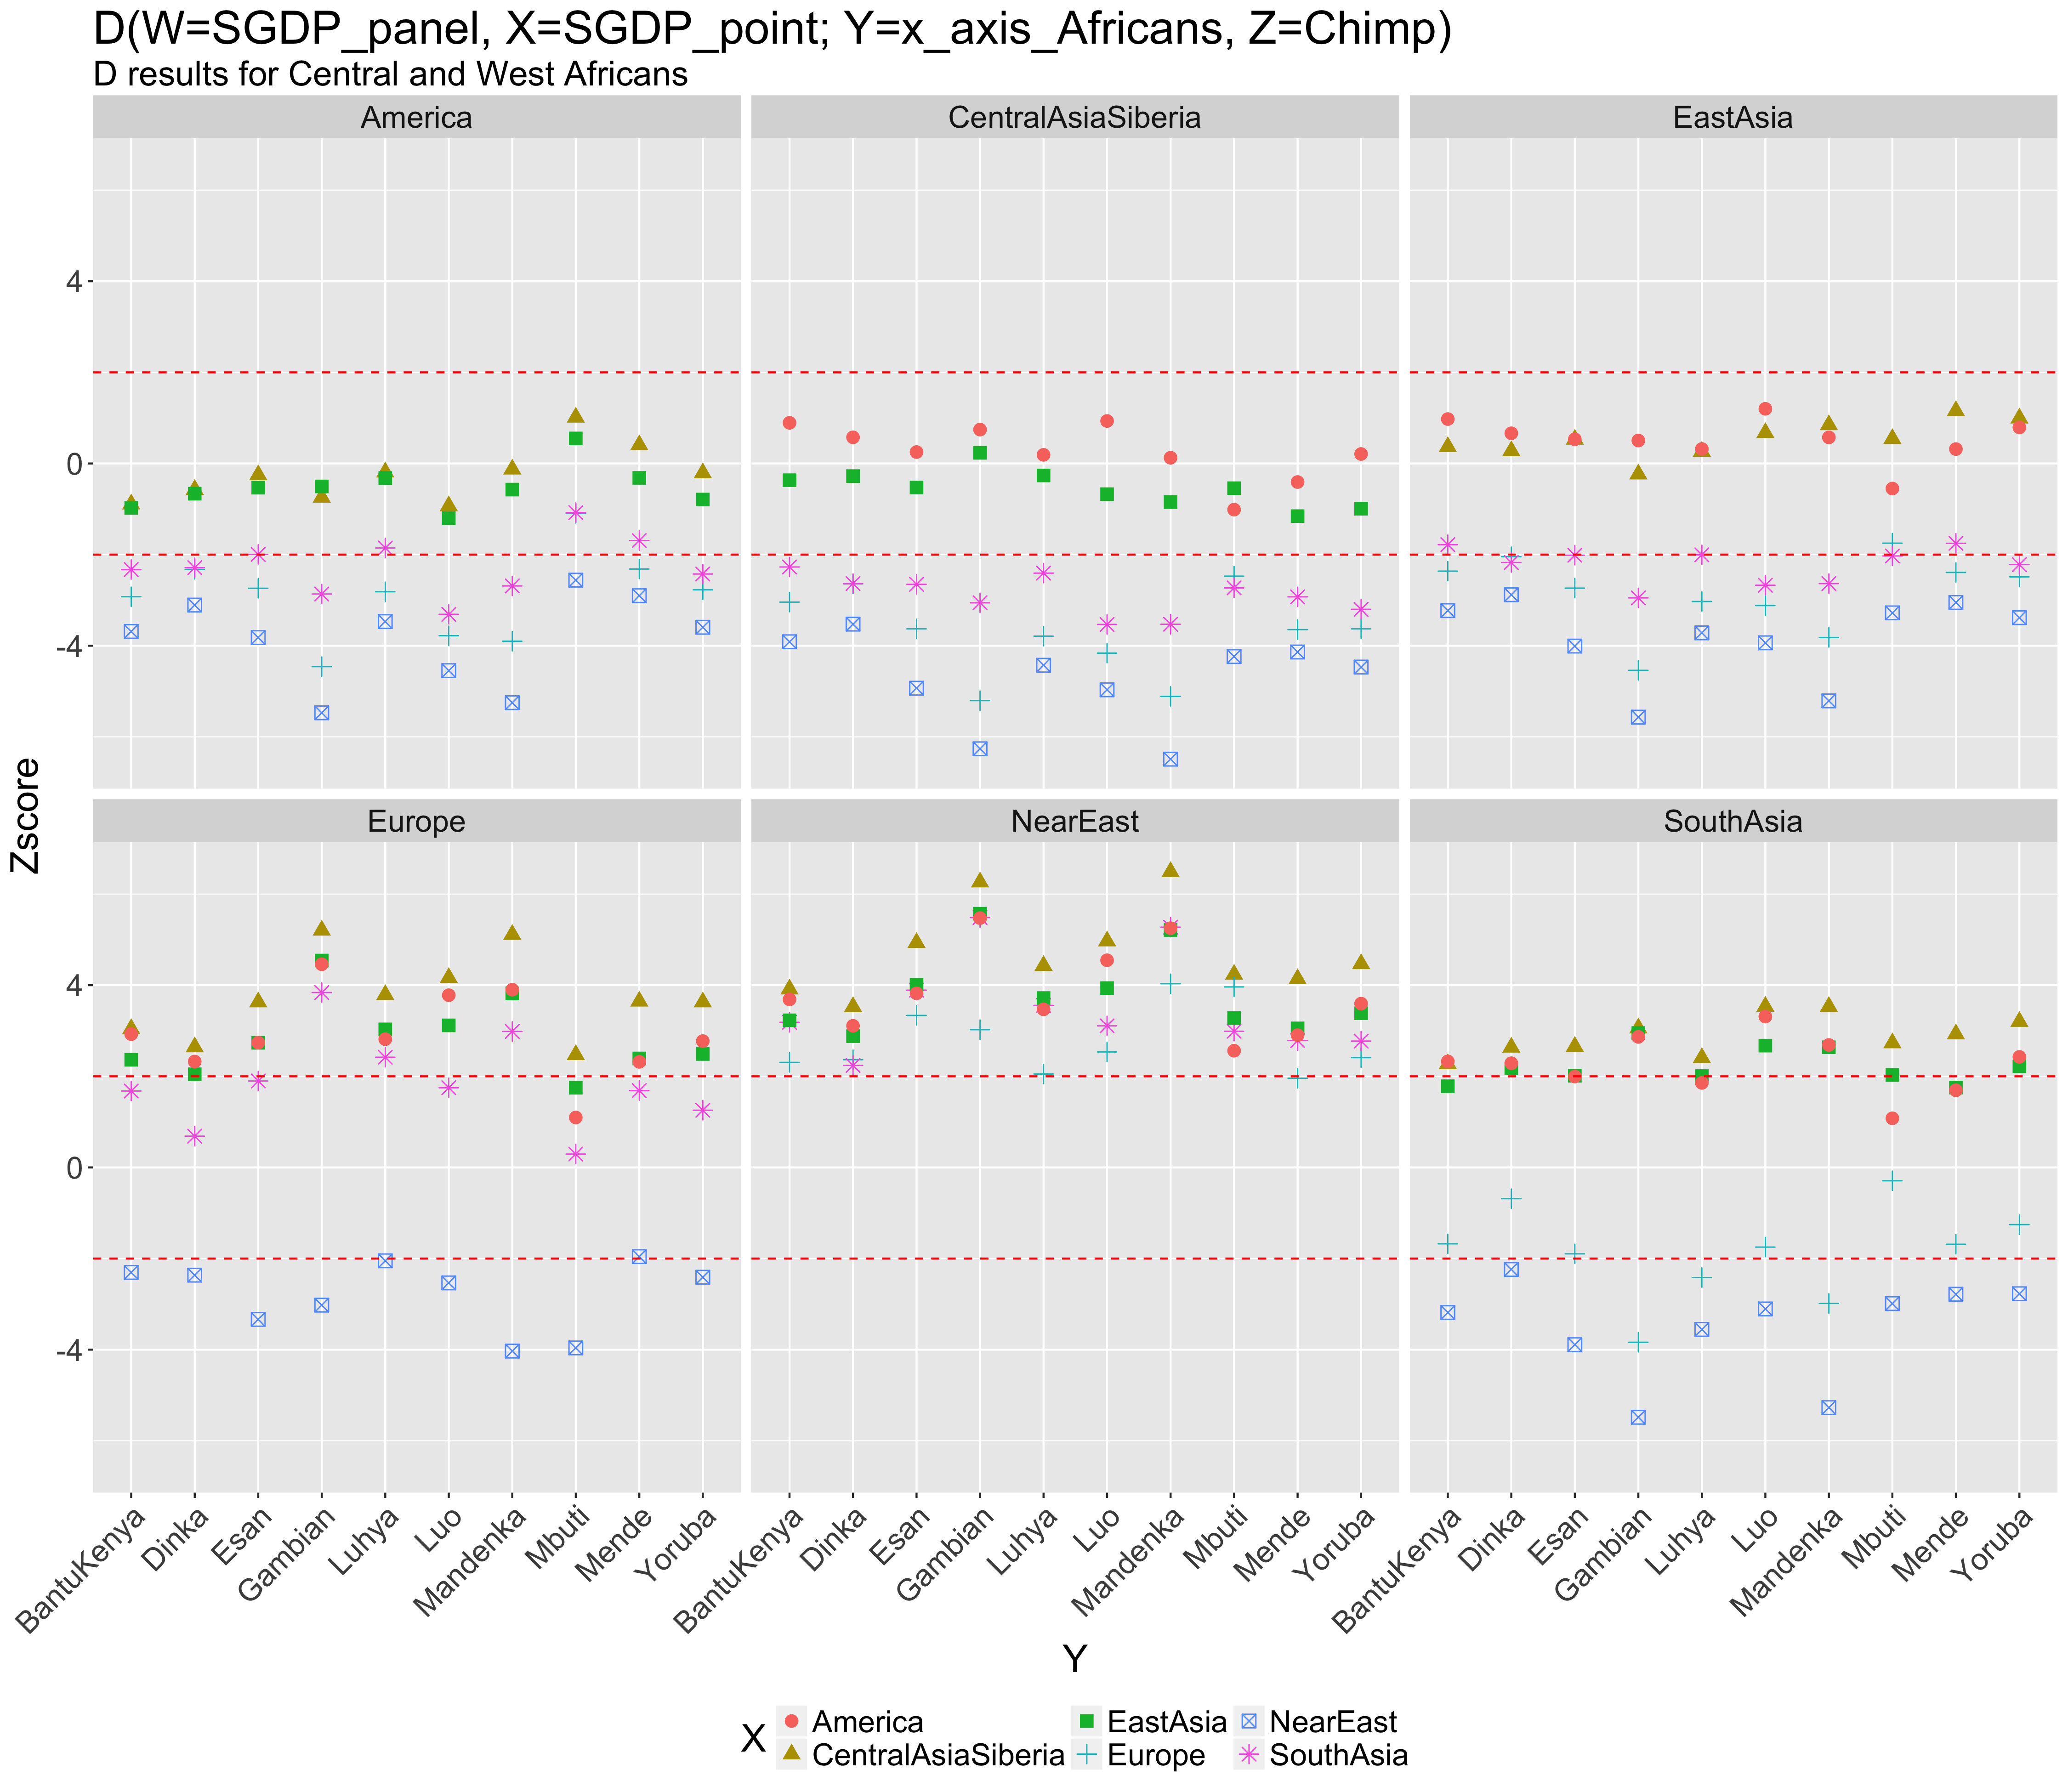

In [646]:
set_dim(15, 13, 300)

backflow_dstats %>% filter(W != "Oceania", X != "Oceania", !Y %in% c("Saharawi", "Mozabite", "Masai", "Somali")) %>% 
ggplot(aes(Y, Zscore, color=X, shape=X)) +
    geom_point(size=3) +
    geom_hline(yintercept=c(-2, 2), linetype=2, color="red") +
    theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1), legend.position="bottom") +
    facet_wrap(~ W) +
    ggtitle(paste0("D(W=SGDP_panel, X=SGDP_point; Y=x_axis_Africans, Z=Chimp)"),
            "D results for Central and West Africans")

In [636]:
save.image("../RData/admixtools_dilution.RData")

Perhaps plot the distributions of significance values of all ancient samples vs all present-day samples next to these scatterplots?

Several observations:

1. Affinity of later early modern humans to the present-day Near East populations, but no change in affinity towards Americans and East Asians (already described by @fu_genetic_2016)

2. __The affinity towards Near East continues to be even stronger going to the present.__ 

3. __South Asia shows a similar trend as the Near East.__

4. It seems that there might be some partitioning in the samples between 15-10ky - almost as if only a subset of samples had a significant Near East ancestry, but others did not.

## Estimating the proportions of Near East and basal Eurasian ancestry

D statistic such as the one used above can be used as a significance test of potential admixture, but does not reveal the actual admixture _proportions_. Therefore, after finding a suggestive evidence of a growing affinity towards Near East, we were interested if there is also an increasing proportion of Near East ancestry (and potentially towards basal Eurasian ancestry?) over time until the present.

We did this by estimating:

1. The proportion of Near East ancestry in each EMH and present-day SGDP European (which should give us an idea about the rate of dilution that potentially happened).

2. The proportion of basal Eurasian ancestry directly.

### 1. Near East admixture proportion over time

To get an estimate of the Near East ancestry in an individual X, we used the following f4 ratio: $\frac{f_4(\textrm{present-day Near East},\textrm{ Mbuti}; \textrm{ test individual X},\textrm{ Vestonice cluster})}{f_4(\textrm{present-day Near East},\textrm{ Mbuti};\textrm{ ancient Near East},\textrm{ Vestonice cluster})}$

In a terminology used by an f4 ratio scheme by @patterson_ancient_2012:

* A = subset of present-day Near Easterners from the SGDP panel
* B = subset of ancient Near Easterners from @lazaridis_genomic_2016 (Levant and Natufians, 8-12ky old)
* C = Vestonice cluster, cluster of ~ 20ky old Europeans
* O = Mbuti
* X = test individual.

![](img/f4ratios2.png)

<del>*TODO* Tianyuan, Ust-Ishim</del>

**TODO** Nea f4 vs near east ancestry

**TODO** Look more closely into a bunch of other ancient farmers.

Merge ancient Near Eastern individuals into an "ancient_NearEast" metapopulation, do a similar thing with present-day Near Easterners.

In [143]:
to_merge <- list(
    ancient_NearEast=c("Levant_N", "Natufian"), 
    present_NearEast=c("Yemenite_Jew", "Jordan", "Samaritan", "Bedouin", "Palestinian"),
    ancient_WestEur=c("Pavlov1", "Vestonice43", "Ostuni1",  "Vestonice15", "Vestoncie16", "Vestonice13")
)

In [144]:
merge_pops(IND_FILE, paste0(IND_FILE, ".merged_pops"), to_merge)

Calculate the Near East $f4$ ratios:

In [145]:
prefix_ancient <- "f4_near_east_ancient"
prefix_modern <- "f4_near_east_modern"

In [146]:
# ancient humans
create_qpF4ratio_pops(X=filter(emhs, !name %in% c("UstIshim", "Kostenki14", "Oase1",
                                       "Pavlov1", "Vestonice43", "Ostuni1",
                                       "Vestonice15", "Vestoncie16", "Vestonice13"))$name,
                   A="present_NearEast", B="ancient_NearEast", C="ancient_WestEur", O="Mbuti",
                   file=paste0(prefix_ancient, ".pop"))
create_param_file(paste0(prefix_ancient, ".par"),
               paste0(prefix_ancient, ".pop"),
               geno_file=GENO_FILE,
               snp_file=SNP_FILE,
               ind_file=paste0(IND_FILE, ".merged_pops"),
               badsnp_file=BADSNP_FILE)
run_cmd("qpF4ratio",
     param_file=paste0(prefix_ancient, ".par"),
     log_file=paste0(prefix_ancient, ".log"))

In [147]:
## modern humans
create_qpF4ratio_pops(X=modern_X,
                   A="present_NearEast", B="ancient_NearEast", C="ancient_WestEur", O="Mbuti",
                   file=paste0(prefix_modern, ".pop"))
create_param_file(paste0(prefix_modern, ".par"),
               paste0(prefix_modern, ".pop"),
               geno_file=GENO_FILE,
               snp_file=SNP_FILE,
               ind_file=paste0(IND_FILE, ".merged_pops"),
               badsnp_file=BADSNP_FILE)
run_cmd("qpF4ratio",
     param_file=paste0(prefix_modern, ".par"),
     log_file=paste0(prefix_modern, ".log"))

Joining, by = "name"
Joining, by = "name"


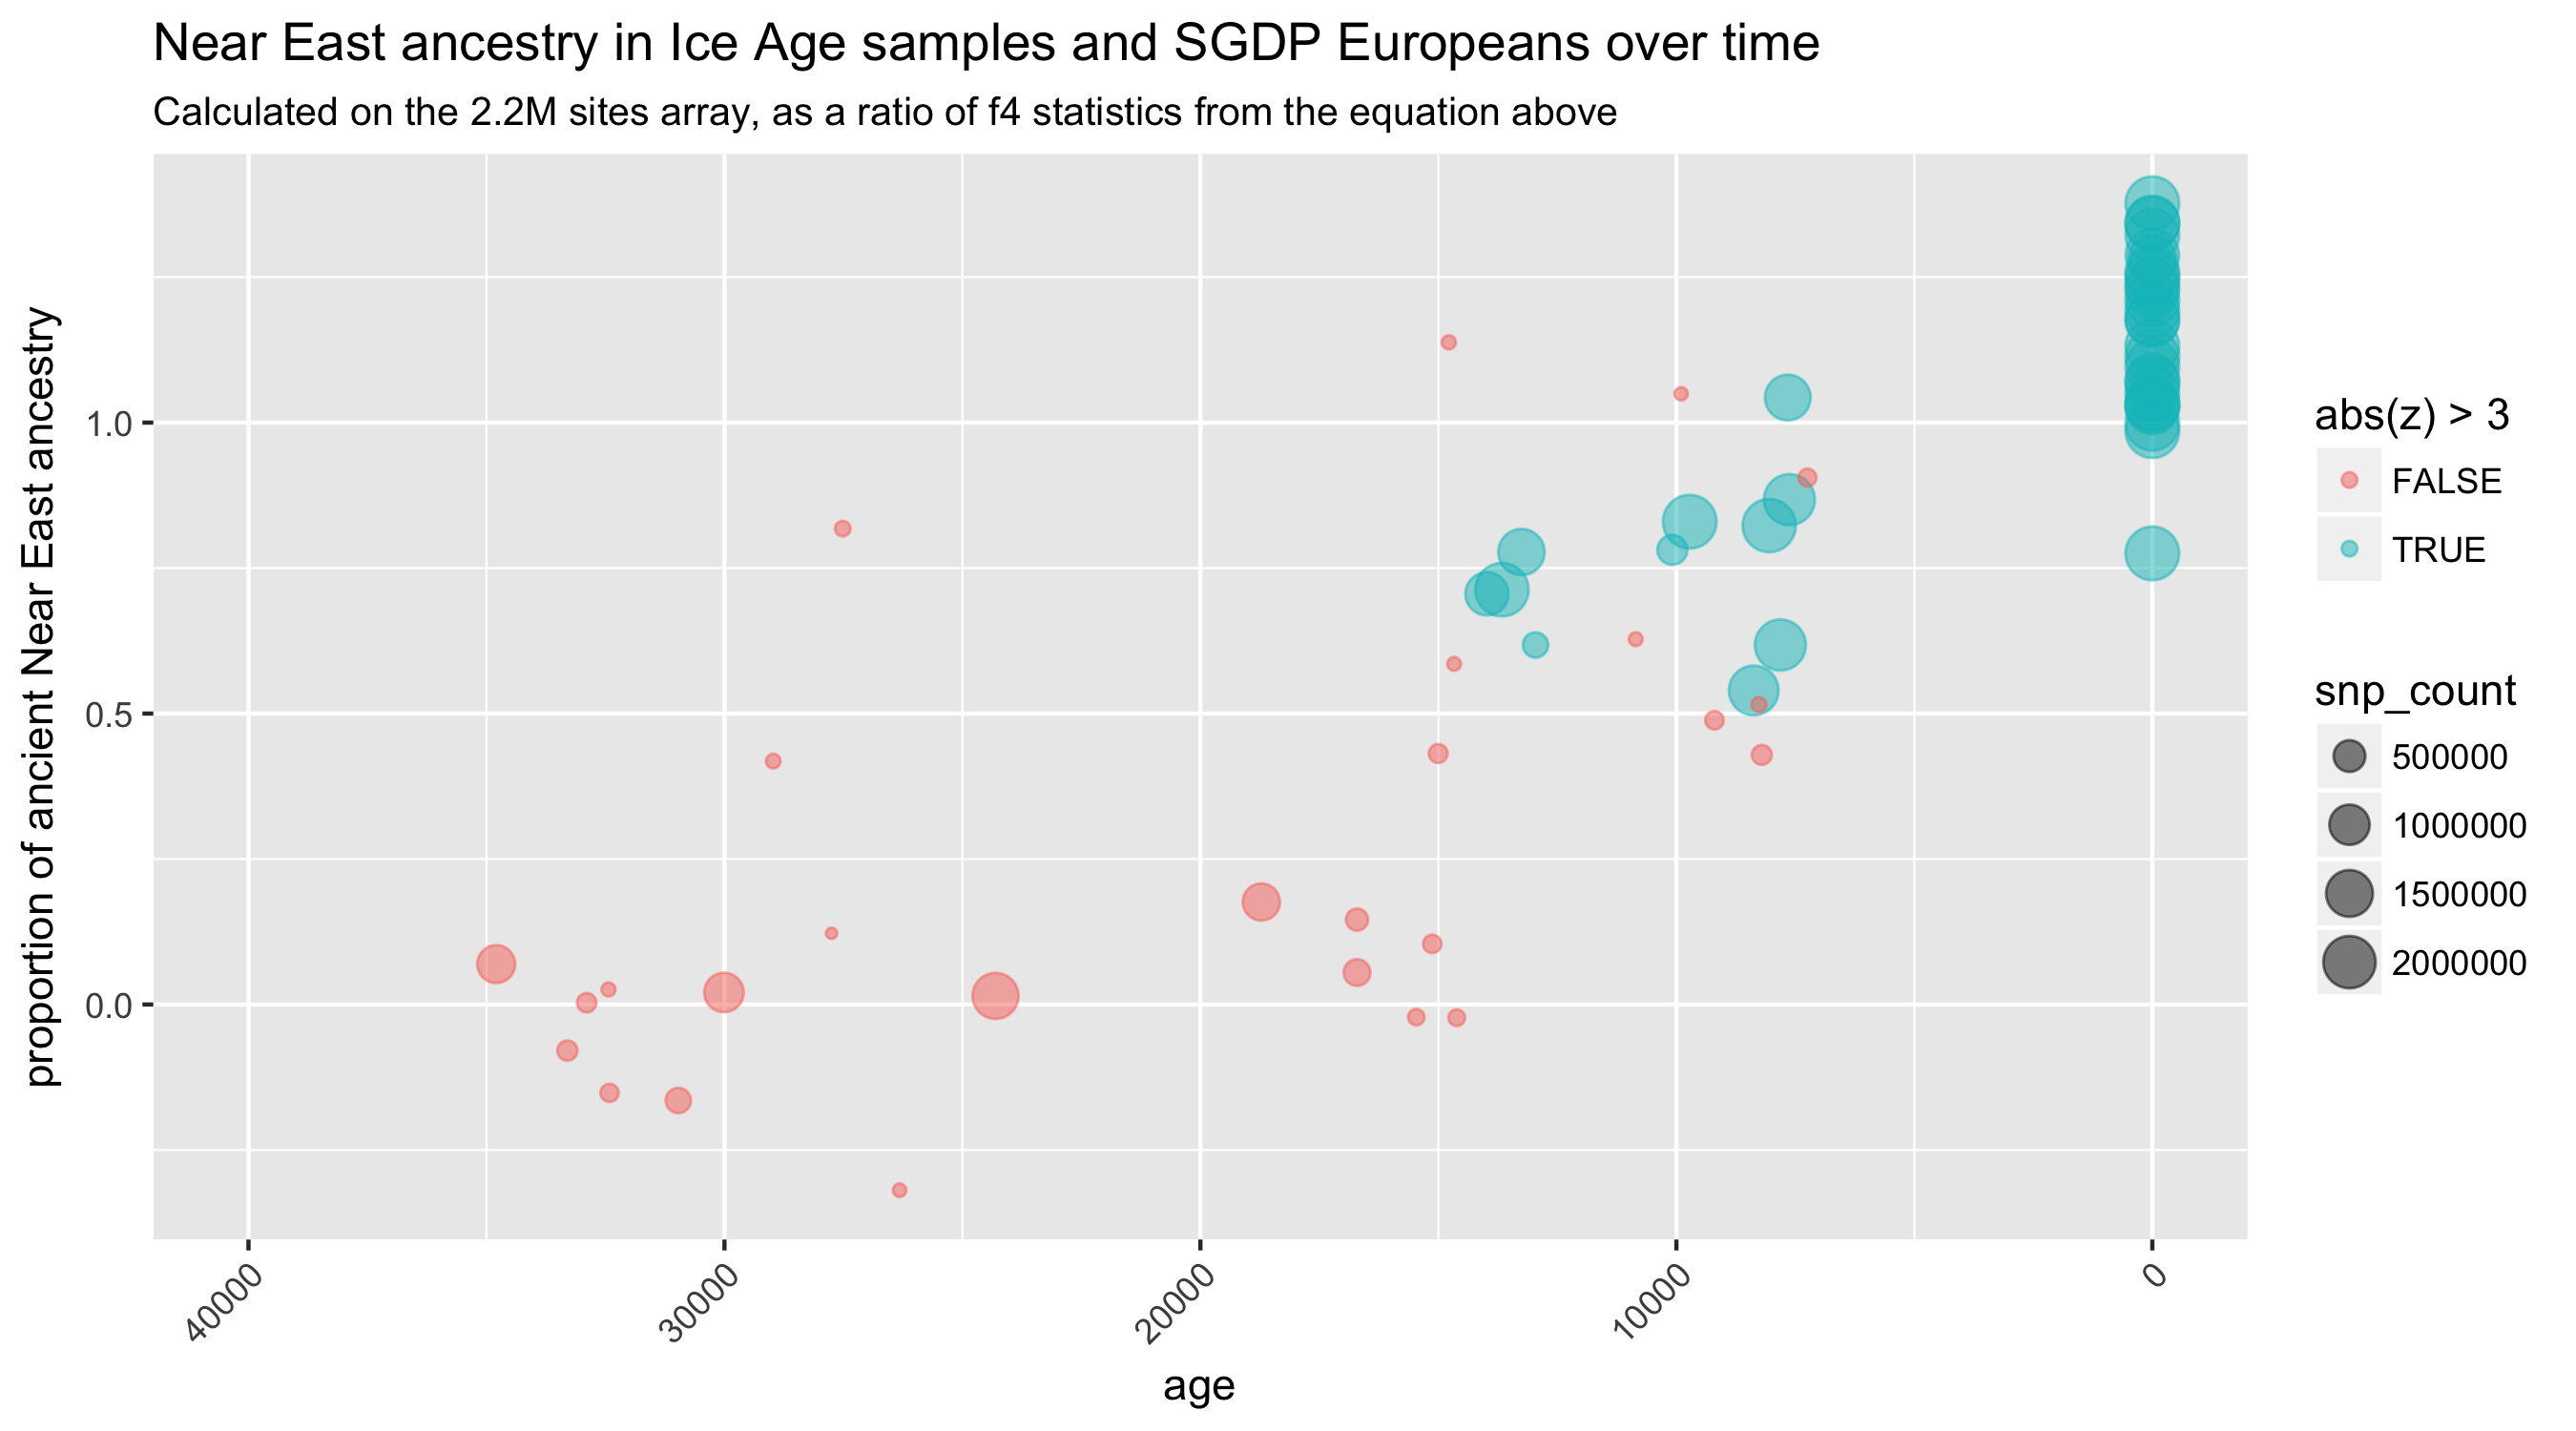

In [148]:
options(repr.plot.width=9, repr.plot.height=5)

near_east_proportion <-
    bind_rows(read_qpF4ratio(paste0(prefix_ancient, ".log")),
              read_qpF4ratio(paste0(prefix_modern, ".log"))) %>%
    rename(name=X) %>%
    inner_join(samples) %>%
    inner_join(snp_counts_f4)


## F4 ratios of Near eastern ancestry in present-day and UP humans over time
near_east_proportion %>% filter(abs(alpha) < 1.5) %>% 
    ggplot(aes(age, alpha)) +
    geom_point(aes(color=abs(z) > 3, size=snp_count), alpha=1/2) +
    xlim(40000, 0) + labs(y="proportion of ancient Near East ancestry") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle("Near East ancestry in Ice Age samples and SGDP Europeans over time",
            subtitle="Calculated on the 2.2M sites array, as a ratio of f4 statistics from the equation above")

In agreement with the D statistics analysis above, this indicates that the proportion of Near Eastern ancestry in Europe:

* Is higher in later ancient samples compared to the earliest ones.
* __Is even higher for the present-day samples__, which suggests that the gene-flow from the Near East continued even during the last ~8 ky.

__Question__: Is there a better way to estimate the proportion of Near East ancestry?

Specifically, present-day humans show a slightly higher proportion of Near East ancestry than 1.0, which could be a sign of an imperfect phylogeny than the one shown in a diagram above. For example, if the population of Vestonice16 are not direct ancestors of present-day Europeans, this would lead to the underestimation of $1 - \alpha$ and, therefore, to the overestimation of $\alpha$ and to it's value above 1.0?

## 2. estimating the basal Eurasian ancestry

While the analysis above is informative about the rate of admixture from an ancient Near Eastern population (and, potentially, about the rate of dilution), it is not an estimate of the basal Eurasian ancestry over time.

To get a direct estimate of the basal Eurasian ancestry, we modified an approach applied in @lazaridis_genomic_2016 (Supplementary note page 23).

We used the following f4 ratio, which is informative about the proportion of basal Eurasian ancestry in an individual Test, described in the following figure (taken from @lazaridis_genomic_2016):

![](img/f4_basal.png)

In our case:

* A = Ust-Ishim, a 45ky old human (who split from present-day humans before the split of Europeans and Asians)

* B = Kostenki14, a 37ky old West Eurasian

* West Eurasian without basal Eurasian admixture = Vestonice 16, 20ky old European

* Test = one of the Ice Age or present-day SGDP Europeans whose basal Eurasian ancestry ($\alpha$) we want to estimate

* African = Mbuti.

In [158]:
to_merge <- list(
    ancient_WestEur=c("Pavlov1", "Vestonice43", "Ostuni1",  "Vestonice15", "Vestoncie16", "Vestonice13")
)

In [159]:
merge_pops(IND_FILE, paste0(IND_FILE, ".merged_ancient_westeur"), to_merge)

In [160]:
calc_basal_alpha <- function(W_afr, W_ancient, W_modern, X, Y, Z, output) {
    ## denominator
    create_Dstats_pops(
        W=W_afr,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_denominator.pop"
    )
    create_param_file(
        param_file="basal_alpha_denominator.par",
        pops_file="basal_alpha_denominator.pop",
        geno_file=GENO_FILE,
               snp_file=SNP_FILE,
               ind_file=paste0(IND_FILE, ".merged_ancient_westeur"),
        badsnp_file=BADSNP_FILE,
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_denominator.par",
            log_file=paste0(output, "_denominator.log"))
    
    ## ancient
    create_Dstats_pops(
        W=W_ancient,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_ancient.pop"
    )
    create_param_file(
        param_file="basal_alpha_ancient.par",
        pops_file="basal_alpha_ancient.pop",
        geno_file=GENO_FILE,
               snp_file=SNP_FILE,
               ind_file=paste0(IND_FILE, ".merged_ancient_westeur"),
        badsnp_file=BADSNP_FILE,
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_ancient.par",
            log_file=paste0(output, "_ancient.log"))
    
    ## modern
    create_Dstats_pops(
        W=W_modern,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_modern.pop"
    )
    create_param_file(
        param_file="basal_alpha_modern.par",
        pops_file="basal_alpha_modern.pop",
        geno_file=GENO_FILE,
               snp_file=SNP_FILE,
               ind_file=paste0(IND_FILE, ".merged_ancient_westeur"),
        badsnp_file=BADSNP_FILE,
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_modern.par",
            log_file=paste0(output, "_modern.log"))
}


read_basal_alpha <- function(output_prefix) {
    blah1 <- read_qpDstat(paste0(output_prefix, "_denominator.log"))
    blah2 <- bind_rows(read_qpDstat(paste0(output_prefix, "_ancient.log")),
                       read_qpDstat(paste0(output_prefix, "_modern.log")))
    
    ## calculate ratios blah2 / blah1
    basal_alpha <- mutate(blah2, alpha=Dstat/blah1$Dstat) %>%
        rename(name=W) %>%
        left_join(samples) %>%
        mutate(name=factor(name, levels=name[order(alpha, decreasing=TRUE)]))
    
    basal_alpha
}

In [161]:
calc_basal_alpha(W_afr="Mbuti",
                 W_ancient=filter(samples, pop == "EMH",
                                           !name %in% c("UstIshim", "Kostenki14", "Oase1",
                                       "Pavlov1", "Vestonice43", "Ostuni1",
                                       "Vestonice15", "Vestoncie16", "Vestonice13"))$name,
                 W_modern=filter(samples, pop == "WestEurasia")$name,
                 X="ancient_WestEur",
                 Y="UstIshim",
                 Z="Kostenki14",
                 output="basal_using_modified_lazaridis_setup")

Joining, by = "name"
Warning message:
“Removed 7 rows containing missing values (geom_point).”

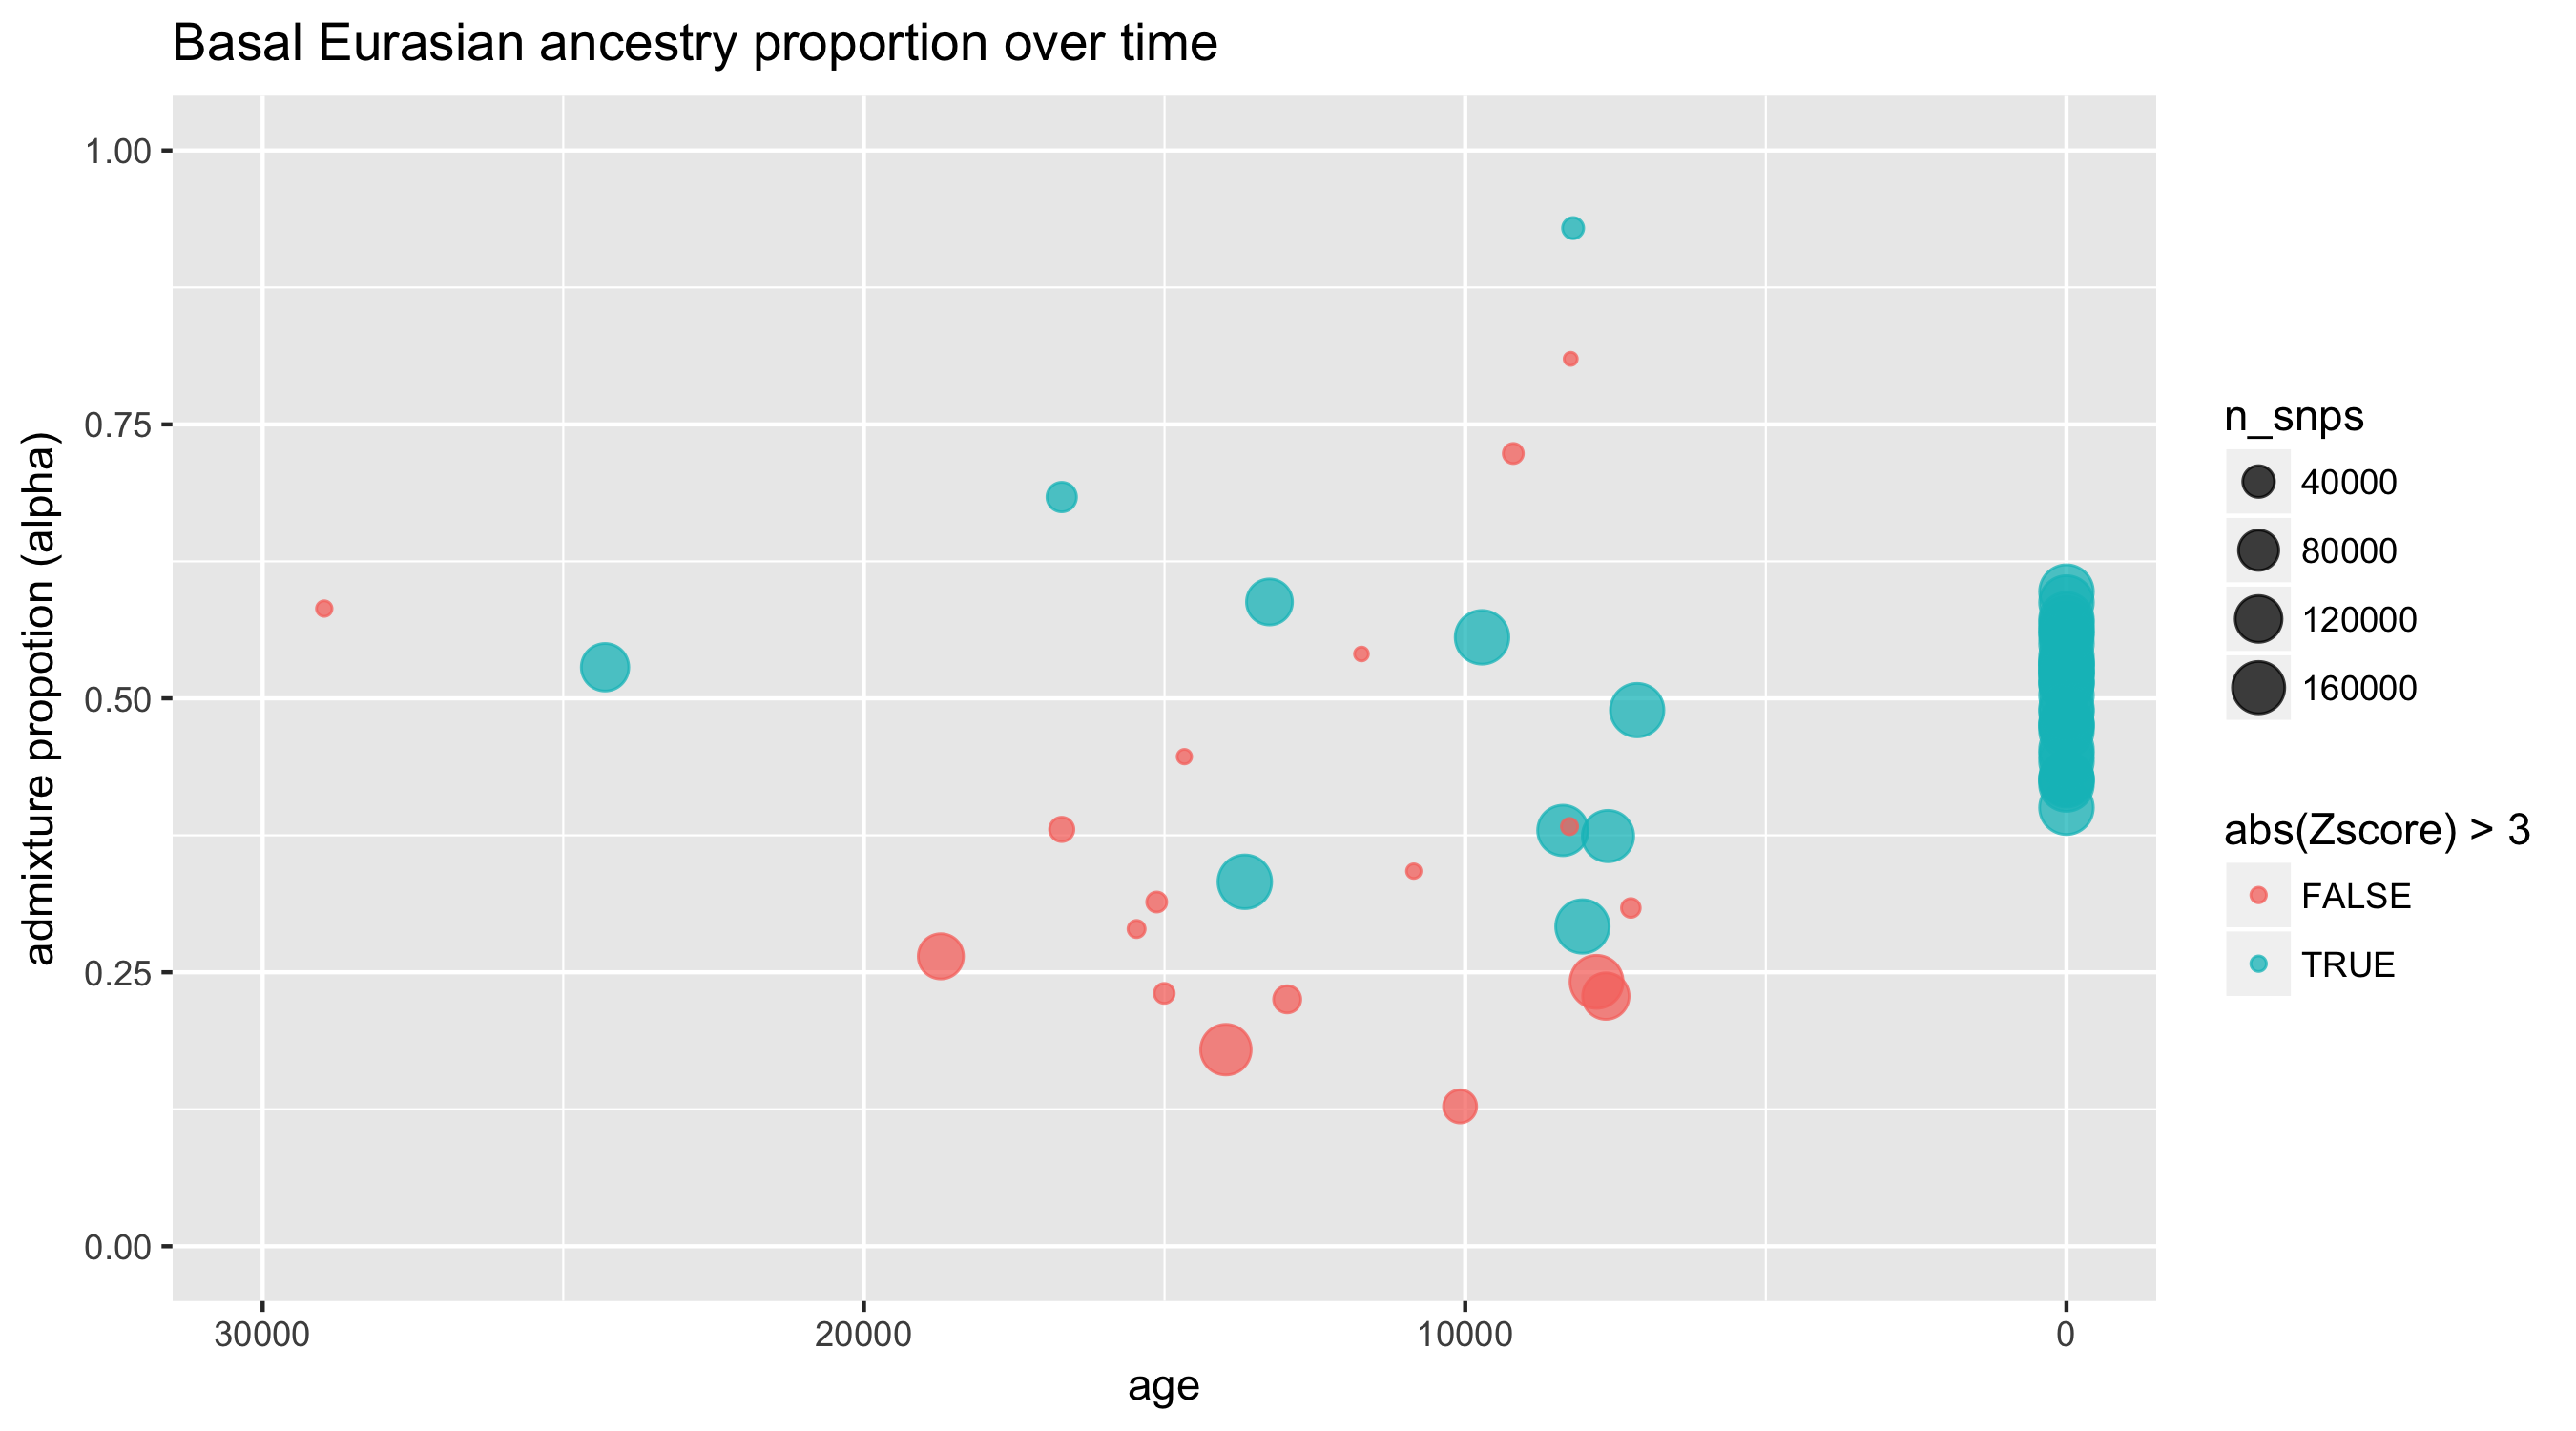

In [181]:
basal_alpha <- read_basal_alpha("basal_using_modified_lazaridis_setup") %>% filter(age < 30000)

## basal Eurasian proportion over time
ggplot(basal_alpha, aes(age, alpha, size=n_snps, color=abs(Zscore) > 3)) +
    geom_point(alpha=0.75) +
    ggtitle("Basal Eurasian ancestry proportion over time") +
    labs(y="admixture propotion (alpha)") +
    xlim(30000, 0) + ylim(0, 1)

This result is in agreement with the previous plots. Although the estimates are noisy, relative comparison of $\alpha$ across time indicates that the proportion of basal Eurasian ancestry has increased.

In [171]:
save.image("../RData/dilution_admixtools.RData")